<a href="https://colab.research.google.com/github/ShreyanshPrajapati/BullsVsBears/blob/main/bulls_vs_bears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Package Imports and Installments**

In [ ]:
!pip install art

In [ ]:
!pip install prophet

  Using cached cmdstanpy-0.9.68-py3-none-any.whl (49 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
!pip install fbprophet

  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from art import *
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly, plot_components_plotly
sns.set_theme(style = 'ticks')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files

# **Reading Data from the data files**

In [ ]:
#From GDrive
NIFTY_data_path = "/content/drive/MyDrive/ALDA/Project/Indexes/^NSEI(NIFTY).csv"
EURONEXT_data_path = "/content/drive/MyDrive/ALDA/Project/Indexes/EURONEXT^N100(EUROPE).csv" 
HXT_data_path = "/content/drive/MyDrive/ALDA/Project/Indexes/HXT.TO(Torronto).csv"
NIKKEI_data_path = "/content/drive/MyDrive/ALDA/Project/Indexes/Nikkei^N225(Japan).csv"
SNS_data_path = "/content/drive/MyDrive/ALDA/Project/Indexes/000001.SS(Shnaghai).csv"
SNP_data_path = "/content/drive/MyDrive/ALDA/Project/Indexes/SNP.csv"

# Locally
# NIFTY_data_path = "/content/^NSEI(NIFTY).csv"
# EURONEXT_data_path = "/content/EURONEXT^N100(EUROPE).csv" 
# HXT_data_path = "/content/HXT.TO(Torronto).csv"
# NIKKEI_data_path = "/content/Nikkei^N225(Japan).csv"
# SNS_data_path = "/content/000001.SS(Shnaghai).csv"
# SNP_data_path = "/content/SNP.csv"

In [ ]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
NIFTY = pd.read_csv(NIFTY_data_path,parse_dates=['Date'], date_parser=dateparse) #/content/drive/MyDrive/ALDA/Project/Indexes/^NSEI(NIFTY).csv
EURONEXT = pd.read_csv(EURONEXT_data_path,parse_dates=['Date'], date_parser=dateparse) #/content/drive/MyDrive/ALDA/Project/Indexes/EURONEXT^N100(EUROPE).csv
HXT = pd.read_csv(HXT_data_path,parse_dates=['Date'], date_parser=dateparse) #/content/drive/MyDrive/ALDA/Project/Indexes/HXT.TO(Torronto).csv
NIKKEI = pd.read_csv(NIKKEI_data_path,parse_dates=['Date'], date_parser=dateparse) #/content/drive/MyDrive/ALDA/Project/Indexes/Nikkei^N225(Japan).csv
SNS = pd.read_csv(SNS_data_path,parse_dates=['Date'], date_parser=dateparse) #/content/drive/MyDrive/ALDA/Project/Indexes/000001.SS(Shnaghai).csv
SNP = pd.read_csv(SNP_data_path,parse_dates=['Date'], date_parser=dateparse) #/content/drive/MyDrive/ALDA/Project/Indexes/SNP.csv

indexes=['NIFTY','EURONEXT',"Torronto Stock Exchange","NIKKEI","SNS","SNP"]

# **Pre - Processing**


## *Defining Fuctions*

In [ ]:
def data_description(data,index):
  statement = "The description for the {} Index:".format(index)
  milestone(statement)

  tprint(index.upper())

  print("Size of {} Index Dataset is {} and ({},{}) containing {} rows and {} columns \n".format(index,
                                                                                data.size,
                                                                                len(data),
                                                                                len(data.columns),
                                                                                len(data),
                                                                                len(data.columns)))

In [ ]:
def milestone(statement,n=100,symbol = "-"):
  print("\n" + statement.center(n,symbol) + "\n")

In [ ]:
def fill_missing_values(data,index):
  null_cols = pd.isnull(data["Open"])
  null_dates = data[null_cols]["Date"]
  # print(null_dates)

  print("There are {} null data point present in the {} index".format(len(null_dates),index))

  for date in null_dates:
    ind = data.index[data["Date"] == date].tolist()[0]

    prev_index = 1
    next_index = 1

    iter = ind

    while(pd.isnull(data.iloc[ind-prev_index]["Open"])):
      prev_index=prev_index+1

    while(pd.isnull(data.iloc[ind+next_index]["Open"])):
      next_index=next_index+1

    data.at[ind,"Open"] = data.iloc[ind- prev_index]["Open"] + ((data.iloc[ind + next_index]["Open"] - data.iloc[ind - prev_index]["Open"])/(prev_index+next_index))
    data.at[ind,"High"] = data.iloc[ind- prev_index]["High"] + ((data.iloc[ind + next_index]["High"] - data.iloc[ind - prev_index]["High"])/(prev_index+next_index))
    data.at[ind,"Low"] = data.iloc[ind- prev_index]["Low"] + ((data.iloc[ind + next_index]["Low"] - data.iloc[ind - prev_index]["Low"])/(prev_index+next_index))
    data.at[ind,"Close"] = data.iloc[ind- prev_index]["Close"] + ((data.iloc[ind + next_index]["Close"] - data.iloc[ind - prev_index]["Close"])/(prev_index+next_index))
    data.at[ind,"Adj Close"] = data.iloc[ind- prev_index]["Adj Close"] + ((data.iloc[ind + next_index]["Adj Close"] - data.iloc[ind - prev_index]["Adj Close"])/(prev_index+next_index))
    data.at[ind,"Volume"] = data.iloc[ind- prev_index]["Volume"] + ((data.iloc[ind + next_index]["Volume"] - data.iloc[ind - prev_index]["Volume"])/(prev_index+next_index))

In [ ]:
def cut_data(data,sdate,edate):
  cut_date = []
  for index in data:
    mask = (index['Date']>=sdate) & (index['Date']<=edate)
    cut = index.loc[mask]
    cut_date.append(cut)
  return cut_date

In [ ]:
def get_date(data,indexes):
  for i in range(0,5):
    print("{} index data contains date from \t{} - {}".format(indexes[i],
                                                             min(data[i]["Date"]),
                                                             max(data[i]["Date"])))

## *Filling Missing Values*

In [ ]:
fill_missing_values(NIFTY,indexes[0])
fill_missing_values(EURONEXT,indexes[1])
fill_missing_values(HXT,indexes[2])
fill_missing_values(NIKKEI,indexes[3])
fill_missing_values(SNS,indexes[4])
fill_missing_values(SNP,indexes[5])

There are 35 null data point present in the NIFTY index
There are 33 null data point present in the EURONEXT index
There are 0 null data point present in the Torronto Stock Exchange index
There are 123 null data point present in the NIKKEI index
There are 129 null data point present in the SNS index
There are 0 null data point present in the SNP index


In [ ]:
dfoflist=[]
dfoflist.append(NIFTY)
dfoflist.append(EURONEXT)
dfoflist.append(HXT)
dfoflist.append(NIKKEI)
dfoflist.append(SNS)
dfoflist.append(SNP)

## *Slicing Data on Date Range*

In [ ]:
sdate = '2011-02-01'
edate = '2021-06-30'

In [ ]:
get_date(dfoflist,indexes)

NIFTY index data contains date from 	2007-12-31 00:00:00 - 2021-08-30 00:00:00
EURONEXT index data contains date from 	2000-01-03 00:00:00 - 2021-09-03 00:00:00
Torronto Stock Exchange index data contains date from 	2011-01-04 00:00:00 - 2021-08-31 00:00:00
NIKKEI index data contains date from 	2000-01-04 00:00:00 - 2021-09-01 00:00:00
SNS index data contains date from 	2000-01-04 00:00:00 - 2021-08-31 00:00:00


In [ ]:
dfoflist = cut_data(dfoflist,sdate,edate)

In [ ]:
get_date(dfoflist,indexes)

NIFTY index data contains date from 	2011-02-01 00:00:00 - 2021-06-30 00:00:00
EURONEXT index data contains date from 	2011-02-01 00:00:00 - 2021-06-30 00:00:00
Torronto Stock Exchange index data contains date from 	2011-02-01 00:00:00 - 2021-06-30 00:00:00
NIKKEI index data contains date from 	2011-02-01 00:00:00 - 2021-06-30 00:00:00
SNS index data contains date from 	2011-02-01 00:00:00 - 2021-06-30 00:00:00


# **Analysis**

## *Indexes Information*

In [ ]:
data_description(NIFTY,indexes[0])
NIFTY.describe()


--------------------------------The description for the NIFTY Index:--------------------------------

 _   _  ___  _____  _____ __   __
| \ | ||_ _||  ___||_   _|\ \ / /
|  \| | | | | |_     | |   \ V / 
| |\  | | | |  _|    | |    | |  
|_| \_||___||_|      |_|    |_|  
                                 

Size of NIFTY Index Dataset is 23611 and (3373,7) containing 3373 rows and 7 columns 



Open          High  ...     Adj Close        Volume
count   3373.000000   3373.000000  ...   3373.000000  3.373000e+03
mean    7855.204270   7901.286513  ...   7849.126166  1.886391e+05
std     3038.185068   3041.711827  ...   3035.034589  2.237492e+05
min     2553.600098   2585.300049  ...   2524.199951  0.000000e+00
25%     5343.250000   5382.049805  ...   5335.149902  0.000000e+00
50%     7688.799805   7726.850098  ...   7683.299805  1.495000e+05
75%    10310.150391  10343.599609  ...  10295.349609  2.498000e+05
max    16775.849609  16951.500000  ...  16931.050781  1.811000e+06

[8 rows x 6 columns]

In [ ]:
NIFTY.head()

Date         Open         High  ...        Close    Adj Close  Volume
0 2007-12-31  6095.000000  6167.750000  ...  6138.600098  6138.600098     0.0
1 2008-01-01  6136.750000  6165.350098  ...  6144.350098  6144.350098     0.0
2 2008-01-02  6144.700195  6197.000000  ...  6179.399902  6179.399902     0.0
3 2008-01-03  6184.250000  6230.149902  ...  6178.549805  6178.549805     0.0
4 2008-01-04  6179.100098  6300.049805  ...  6274.299805  6274.299805     0.0

[5 rows x 7 columns]

In [ ]:
NIFTY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3373 non-null   datetime64[ns]
 1   Open       3373 non-null   float64       
 2   High       3373 non-null   float64       
 3   Low        3373 non-null   float64       
 4   Close      3373 non-null   float64       
 5   Adj Close  3373 non-null   float64       
 6   Volume     3373 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 184.6 KB


In [ ]:
data_description(EURONEXT,indexes[1])
EURONEXT.describe()


------------------------------The description for the EURONEXT Index:-------------------------------

 _____  _   _  ____    ___   _   _  _____ __  __ _____ 
| ____|| | | ||  _ \  / _ \ | \ | || ____|\ \/ /|_   _|
|  _|  | | | || |_) || | | ||  \| ||  _|   \  /   | |  
| |___ | |_| ||  _ < | |_| || |\  || |___  /  \   | |  
|_____| \___/ |_| \_\ \___/ |_| \_||_____|/_/\_\  |_|  
                                                       

Size of EURONEXT Index Dataset is 39011 and (5573,7) containing 5573 rows and 7 columns 



Open         High  ...    Adj Close        Volume
count  5573.000000  5573.000000  ...  5573.000000  5.573000e+03
mean    827.388359   831.942222  ...   827.295474  1.944480e+08
std     187.110645   186.847766  ...   187.207452  1.647801e+08
min     427.600006   436.519989  ...   419.950012  0.000000e+00
25%     665.239990   668.780029  ...   665.210022  0.000000e+00
50%     831.380005   837.789978  ...   831.929993  2.034314e+08
75%     987.659973   992.260010  ...   986.950012  2.901872e+08
max    1326.729980  1330.069946  ...  1327.640015  1.159639e+09

[8 rows x 6 columns]

In [ ]:
EURONEXT.head()

Date        Open        High  ...       Close   Adj Close  Volume
0 2000-01-03  996.770020  996.770020  ...  996.770020  996.770020     0.0
1 2000-01-04  955.969971  955.969971  ...  955.969971  955.969971     0.0
2 2000-01-05  930.260010  930.260010  ...  930.260010  930.260010     0.0
3 2000-01-06  922.460022  922.460022  ...  922.460022  922.460022     0.0
4 2000-01-07  943.880005  943.880005  ...  943.880005  943.880005     0.0

[5 rows x 7 columns]

In [ ]:
EURONEXT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5573 non-null   datetime64[ns]
 1   Open       5573 non-null   float64       
 2   High       5573 non-null   float64       
 3   Low        5573 non-null   float64       
 4   Close      5573 non-null   float64       
 5   Adj Close  5573 non-null   float64       
 6   Volume     5573 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 304.9 KB


In [ ]:
data_description(HXT,indexes[2])
HXT.describe()


-----------------------The description for the Torronto Stock Exchange Index:-----------------------

 _____   ___   ____   ____    ___   _   _  _____   ___    ____   _____   ___    ____  _  __  _____ __  __  ____  _   _     _     _   _   ____  _____ 
|_   _| / _ \ |  _ \ |  _ \  / _ \ | \ | ||_   _| / _ \  / ___| |_   _| / _ \  / ___|| |/ / | ____|\ \/ / / ___|| | | |   / \   | \ | | / ___|| ____|
  | |  | | | || |_) || |_) || | | ||  \| |  | |  | | | | \___ \   | |  | | | || |    | ' /  |  _|   \  / | |    | |_| |  / _ \  |  \| || |  _ |  _|  
  | |  | |_| ||  _ < |  _ < | |_| || |\  |  | |  | |_| |  ___) |  | |  | |_| || |___ | . \  | |___  /  \ | |___ |  _  | / ___ \ | |\  || |_| || |___ 
  |_|   \___/ |_| \_\|_| \_\ \___/ |_| \_|  |_|   \___/  |____/   |_|   \___/  \____||_|\_\ |_____|/_/\_\ \____||_| |_|/_/   \_\|_| \_| \____||_____|
                                                                                                                                                   

Open         High  ...    Adj Close        Volume
count  2676.000000  2676.000000  ...  2676.000000  2.676000e+03
mean     29.217960    29.329630  ...    29.202829  2.805338e+05
std       6.836703     6.851550  ...     6.839929  3.509649e+05
min      18.340000    18.639999  ...    18.620001  5.000000e+03
25%      22.897500    23.020000  ...    22.879999  9.881250e+04
50%      28.299999    28.370001  ...    28.270000  1.870000e+05
75%      33.930000    34.009998  ...    33.852500  3.339250e+05
max      48.360001    48.529999  ...    48.410000  7.514600e+06

[8 rows x 6 columns]

In [ ]:
HXT.head()

Date       Open       High    Low      Close  Adj Close  Volume
0 2011-01-04  22.000000  22.020000  21.68  21.799999  21.799999  460050
1 2011-01-05  21.780001  21.820000  21.66  21.820000  21.820000  184150
2 2011-01-06  21.860001  21.860001  21.66  21.700001  21.700001  361850
3 2011-01-07  21.639999  21.700001  21.58  21.600000  21.600000  187050
4 2011-01-10  21.719999  21.719999  21.40  21.559999  21.559999  749150

In [ ]:
HXT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676 entries, 0 to 2675
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2676 non-null   datetime64[ns]
 1   Open       2676 non-null   float64       
 2   High       2676 non-null   float64       
 3   Low        2676 non-null   float64       
 4   Close      2676 non-null   float64       
 5   Adj Close  2676 non-null   float64       
 6   Volume     2676 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 146.5 KB


In [ ]:
data_description(NIKKEI,indexes[3])
NIKKEI.describe()


-------------------------------The description for the NIKKEI Index:--------------------------------

 _   _  ___  _  __ _  __ _____  ___ 
| \ | ||_ _|| |/ /| |/ /| ____||_ _|
|  \| | | | | ' / | ' / |  _|   | | 
| |\  | | | | . \ | . \ | |___  | | 
|_| \_||___||_|\_\|_|\_\|_____||___|
                                    

Size of NIKKEI Index Dataset is 38017 and (5431,7) containing 5431 rows and 7 columns 



Open          High  ...     Adj Close        Volume
count   5431.000000   5431.000000  ...   5431.000000  5.431000e+03
mean   15050.056806  15142.445341  ...  15046.383493  1.036135e+08
std     5208.160116   5225.005286  ...   5209.183370  6.220763e+07
min     7059.770020   7100.770020  ...   7054.979980  0.000000e+00
25%    10472.570312  10552.020019  ...  10472.509766  6.490000e+07
50%    14461.639648  14547.799805  ...  14457.563151  1.044000e+08
75%    18932.040039  19056.455078  ...  18912.679688  1.407500e+08
max    30366.820313  30714.519531  ...  30467.750000  5.952000e+08

[8 rows x 6 columns]

In [ ]:
NIKKEI.head()

Date          Open          High  ...         Close     Adj Close  Volume
0 2000-01-04  18937.449219  19187.609375  ...  19002.859375  19002.859375     0.0
1 2000-01-05  19003.509766  19003.509766  ...  18542.550781  18542.550781     0.0
2 2000-01-06  18574.009766  18582.740234  ...  18168.269531  18168.269531     0.0
3 2000-01-07  18194.050781  18285.730469  ...  18193.410156  18193.410156     0.0
4 2000-01-10  18220.075195  18586.645508  ...  18522.165039  18522.165039     0.0

[5 rows x 7 columns]

In [ ]:
NIKKEI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5431 entries, 0 to 5430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5431 non-null   datetime64[ns]
 1   Open       5431 non-null   float64       
 2   High       5431 non-null   float64       
 3   Low        5431 non-null   float64       
 4   Close      5431 non-null   float64       
 5   Adj Close  5431 non-null   float64       
 6   Volume     5431 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 297.1 KB


In [ ]:
data_description(SNS,indexes[4])
SNS.describe()


---------------------------------The description for the SNS Index:---------------------------------

 ____   _   _  ____  
/ ___| | \ | |/ ___| 
\___ \ |  \| |\___ \ 
 ___) || |\  | ___) |
|____/ |_| \_||____/ 
                     

Size of SNS Index Dataset is 37618 and (5374,7) containing 5374 rows and 7 columns 



Open         High  ...    Adj Close        Volume
count  5374.000000  5374.000000  ...  5374.000000  5.374000e+03
mean   2502.010496  2524.050265  ...  2504.223993  1.194773e+05
std     882.875875   893.239487  ...   883.802113  1.833943e+05
min    1007.901001  1019.921997  ...  1011.499023  0.000000e+00
25%    1750.907013  1766.118713  ...  1746.164764  1.661875e+04
50%    2432.182983  2449.851929  ...  2433.817993  9.040000e+04
75%    3089.535034  3110.975402  ...  3092.200257  1.638000e+05
max    6057.428223  6124.043945  ...  6092.057129  1.006520e+07

[8 rows x 6 columns]

In [ ]:
SNS.head()

Date         Open         High  ...        Close    Adj Close  Volume
0 2000-01-04  1368.692993  1407.517944  ...  1406.370972  1406.370972     0.0
1 2000-01-05  1407.828979  1433.780029  ...  1409.682007  1409.682007     0.0
2 2000-01-06  1406.036011  1463.954956  ...  1463.942017  1463.942017     0.0
3 2000-01-07  1477.154053  1522.824951  ...  1516.604004  1516.604004     0.0
4 2000-01-10  1531.712036  1546.723022  ...  1545.112061  1545.112061     0.0

[5 rows x 7 columns]

In [ ]:
SNS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5374 non-null   datetime64[ns]
 1   Open       5374 non-null   float64       
 2   High       5374 non-null   float64       
 3   Low        5374 non-null   float64       
 4   Close      5374 non-null   float64       
 5   Adj Close  5374 non-null   float64       
 6   Volume     5374 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 294.0 KB


In [ ]:
data_description(SNP,indexes[5])
SNP.describe()


---------------------------------The description for the SNP Index:---------------------------------

 ____   _   _  ____  
/ ___| | \ | ||  _ \ 
\___ \ |  \| || |_) |
 ___) || |\  ||  __/ 
|____/ |_| \_||_|    
                     

Size of SNP Index Dataset is 38157 and (5451,7) containing 5451 rows and 7 columns 



Open         High          Low        Close    Adj Close
count  5451.000000  5451.000000  5451.000000  5451.000000  5451.000000
mean   1729.131581  1739.057806  1718.418266  1729.404568  1729.404568
std     789.531315   792.158046   786.837558   789.900066   789.900066
min     679.280000   695.270000   666.790000   676.530000   676.530000
25%    1171.170000  1178.750000  1162.400000  1171.230000  1171.230000
50%    1402.320000  1409.690000  1393.830000  1402.310000  1402.310000
75%    2101.695000  2109.000000  2092.140000  2102.105000  2102.105000
max    4529.750000  4537.360000  4515.800000  4528.790000  4528.790000

In [ ]:
SNP.head()

Date     Open     High      Low    Close  Adj Close         Volume
0 2021-08-31  4529.75  4531.39  4515.80  4522.68    4522.68  3090380000.00
1 2021-08-30  4513.76  4537.36  4513.76  4528.79    4528.79  2557300000.00
2 2021-08-27  4474.10  4513.33  4474.10  4509.37    4509.37  2862360000.00
3 2021-08-26  4493.75  4495.90  4468.99  4470.00    4470.00  2704600000.00
4 2021-08-25  4490.45  4501.71  4485.66  4496.19    4496.19  2554680000.00

In [ ]:
SNP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5451 entries, 0 to 5450
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5451 non-null   datetime64[ns]
 1   Open       5451 non-null   float64       
 2   High       5451 non-null   float64       
 3   Low        5451 non-null   float64       
 4   Close      5451 non-null   float64       
 5   Adj Close  5451 non-null   float64       
 6   Volume     5451 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 298.2+ KB


In [ ]:
def plot(data, index, col,i):
  plt.subplot(6, 1, i)
  plt.plot(data['Date'],data[col],'b',linewidth=3)
  if(col=='Close'):
    plt.title('Closing Values of {}\n'.format(index),fontsize = 24,
            fontweight="bold" )
  if(col=='Volume'):
    plt.title('Volume Values of {}\n'.format(index),fontsize = 24,
            fontweight="bold" )
  plt.xlabel('Time Range',fontsize = 16)
  plt.ylabel('Closing Values',fontsize = 16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  # plt.grid(True)

## *Closing Values of all Indexes*

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

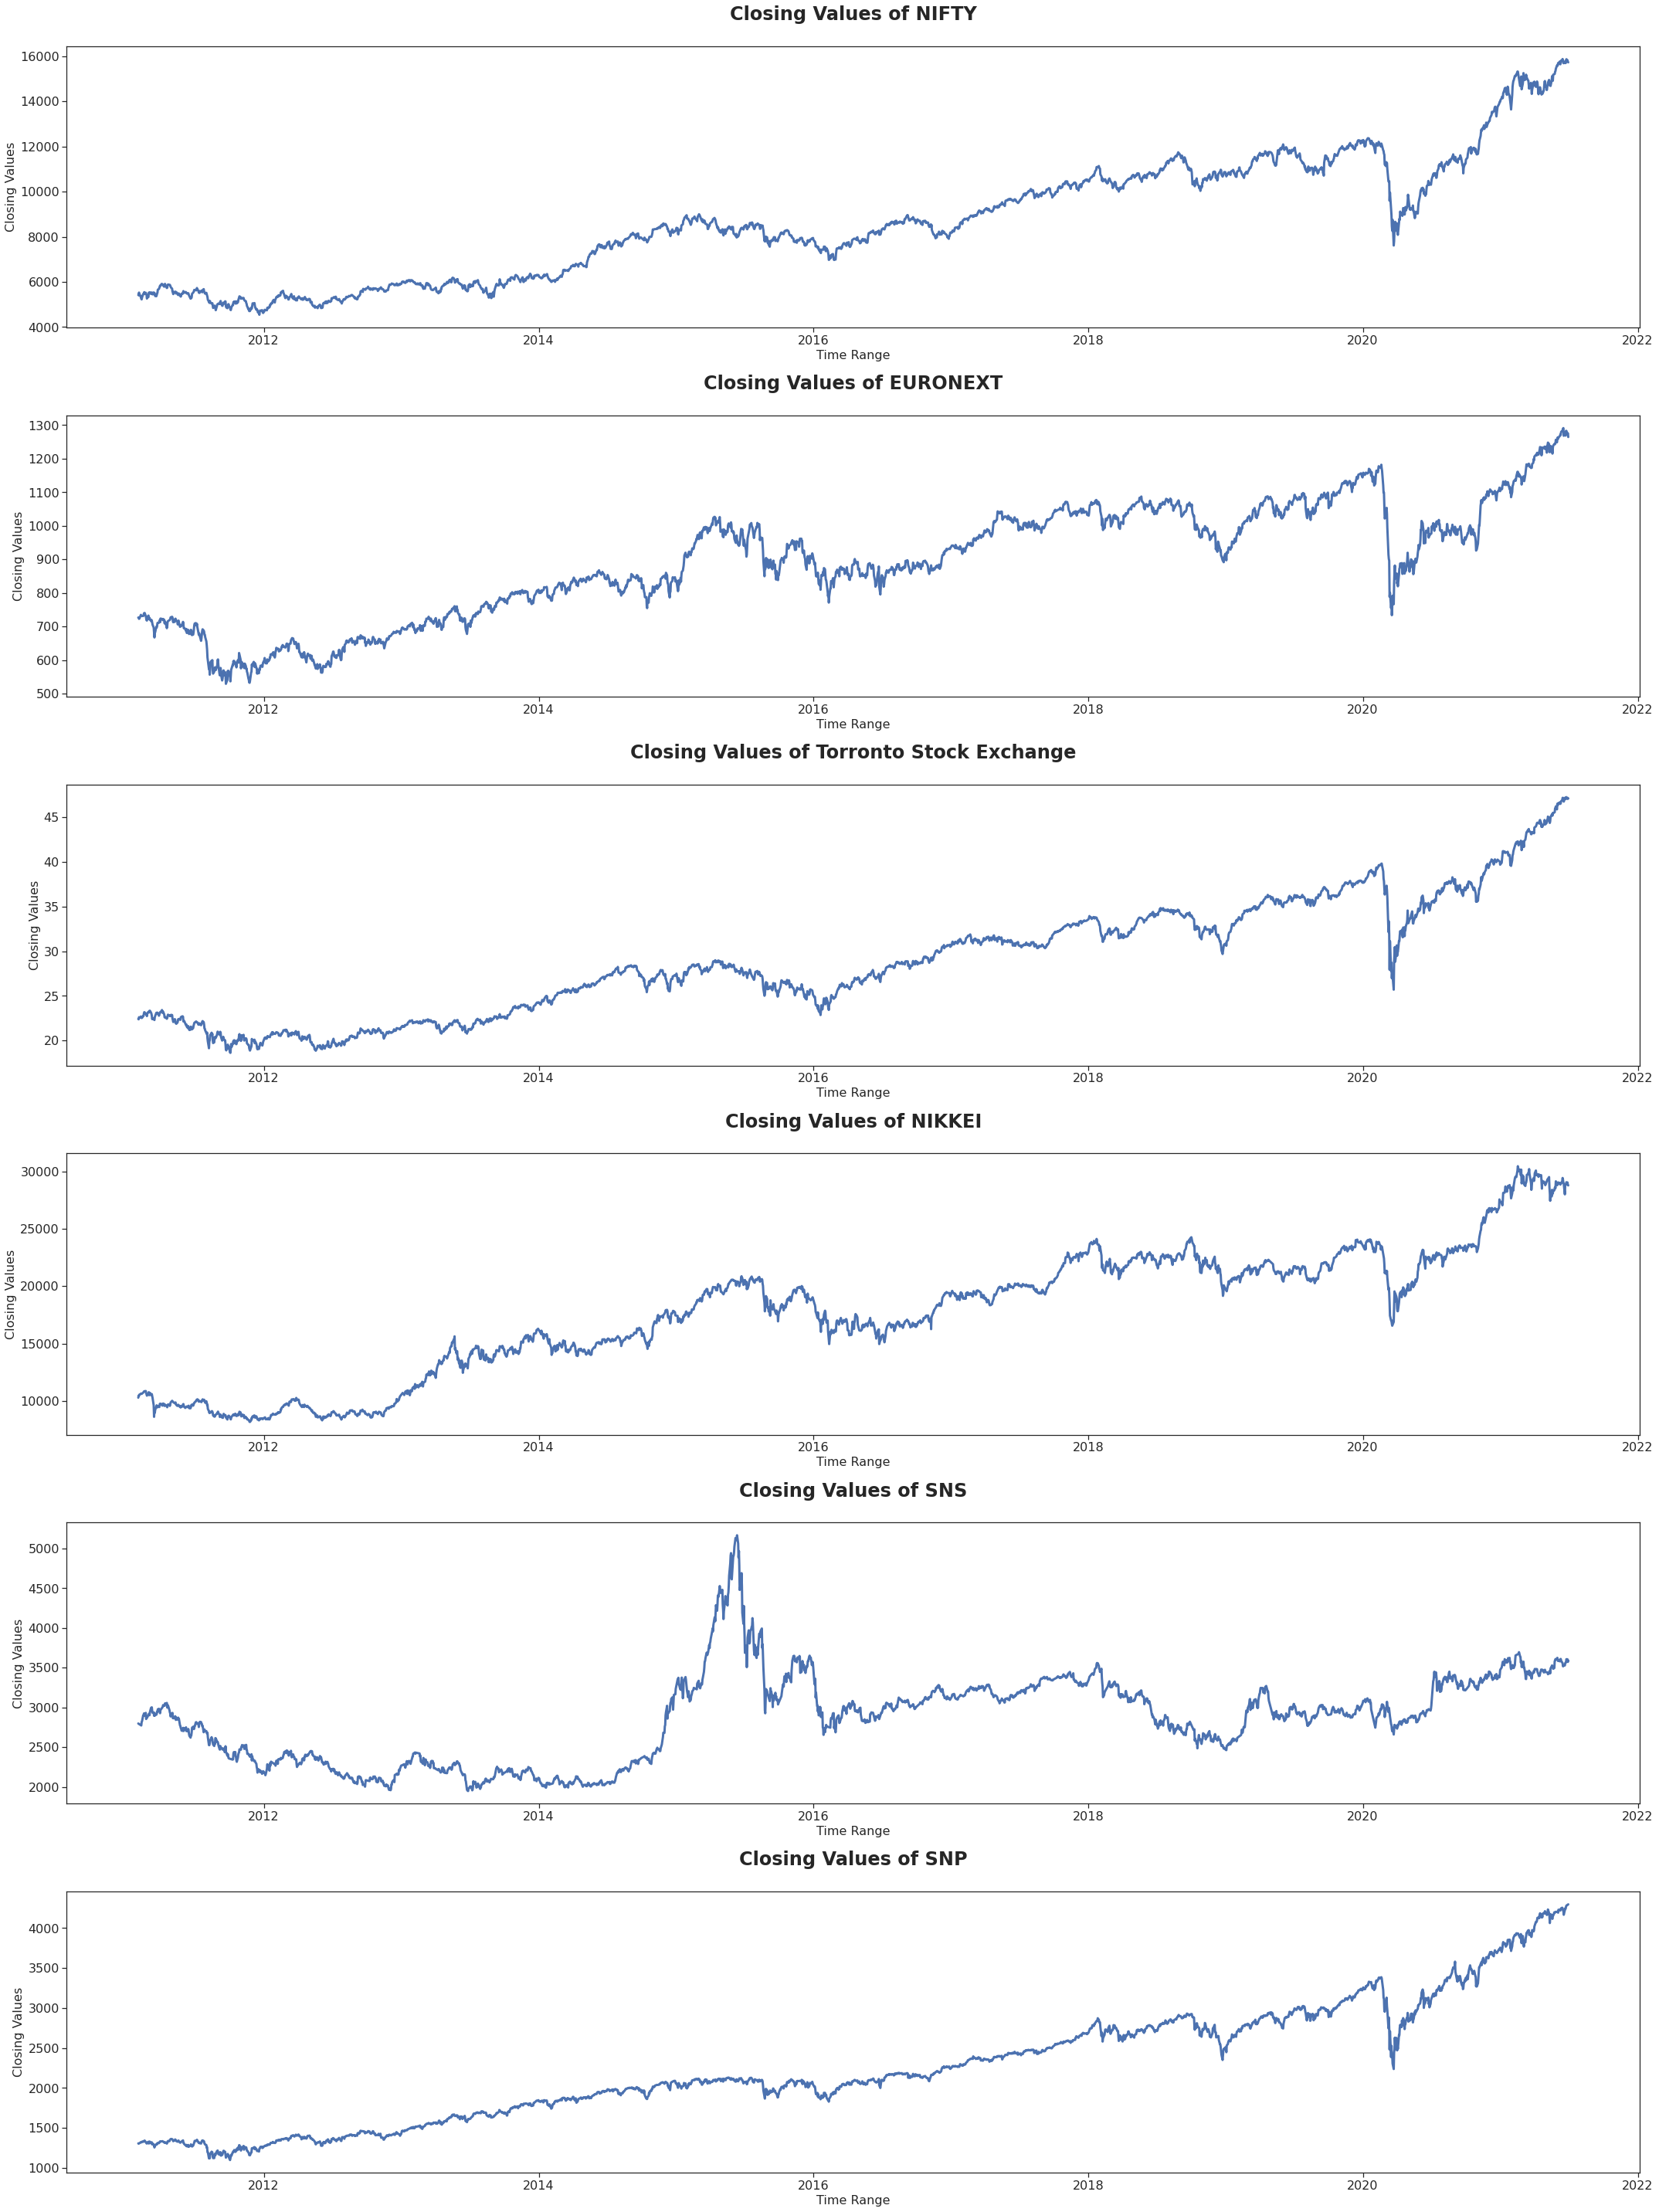

In [ ]:
fig = plt.figure(figsize=(30,40))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i in range(0,len(indexes)):
  plot(dfoflist[i], indexes[i],'Close',i+1)

plt.tight_layout()
plt.savefig('Fig1:Closing_values.png')
files.download("Fig1:Closing_values.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

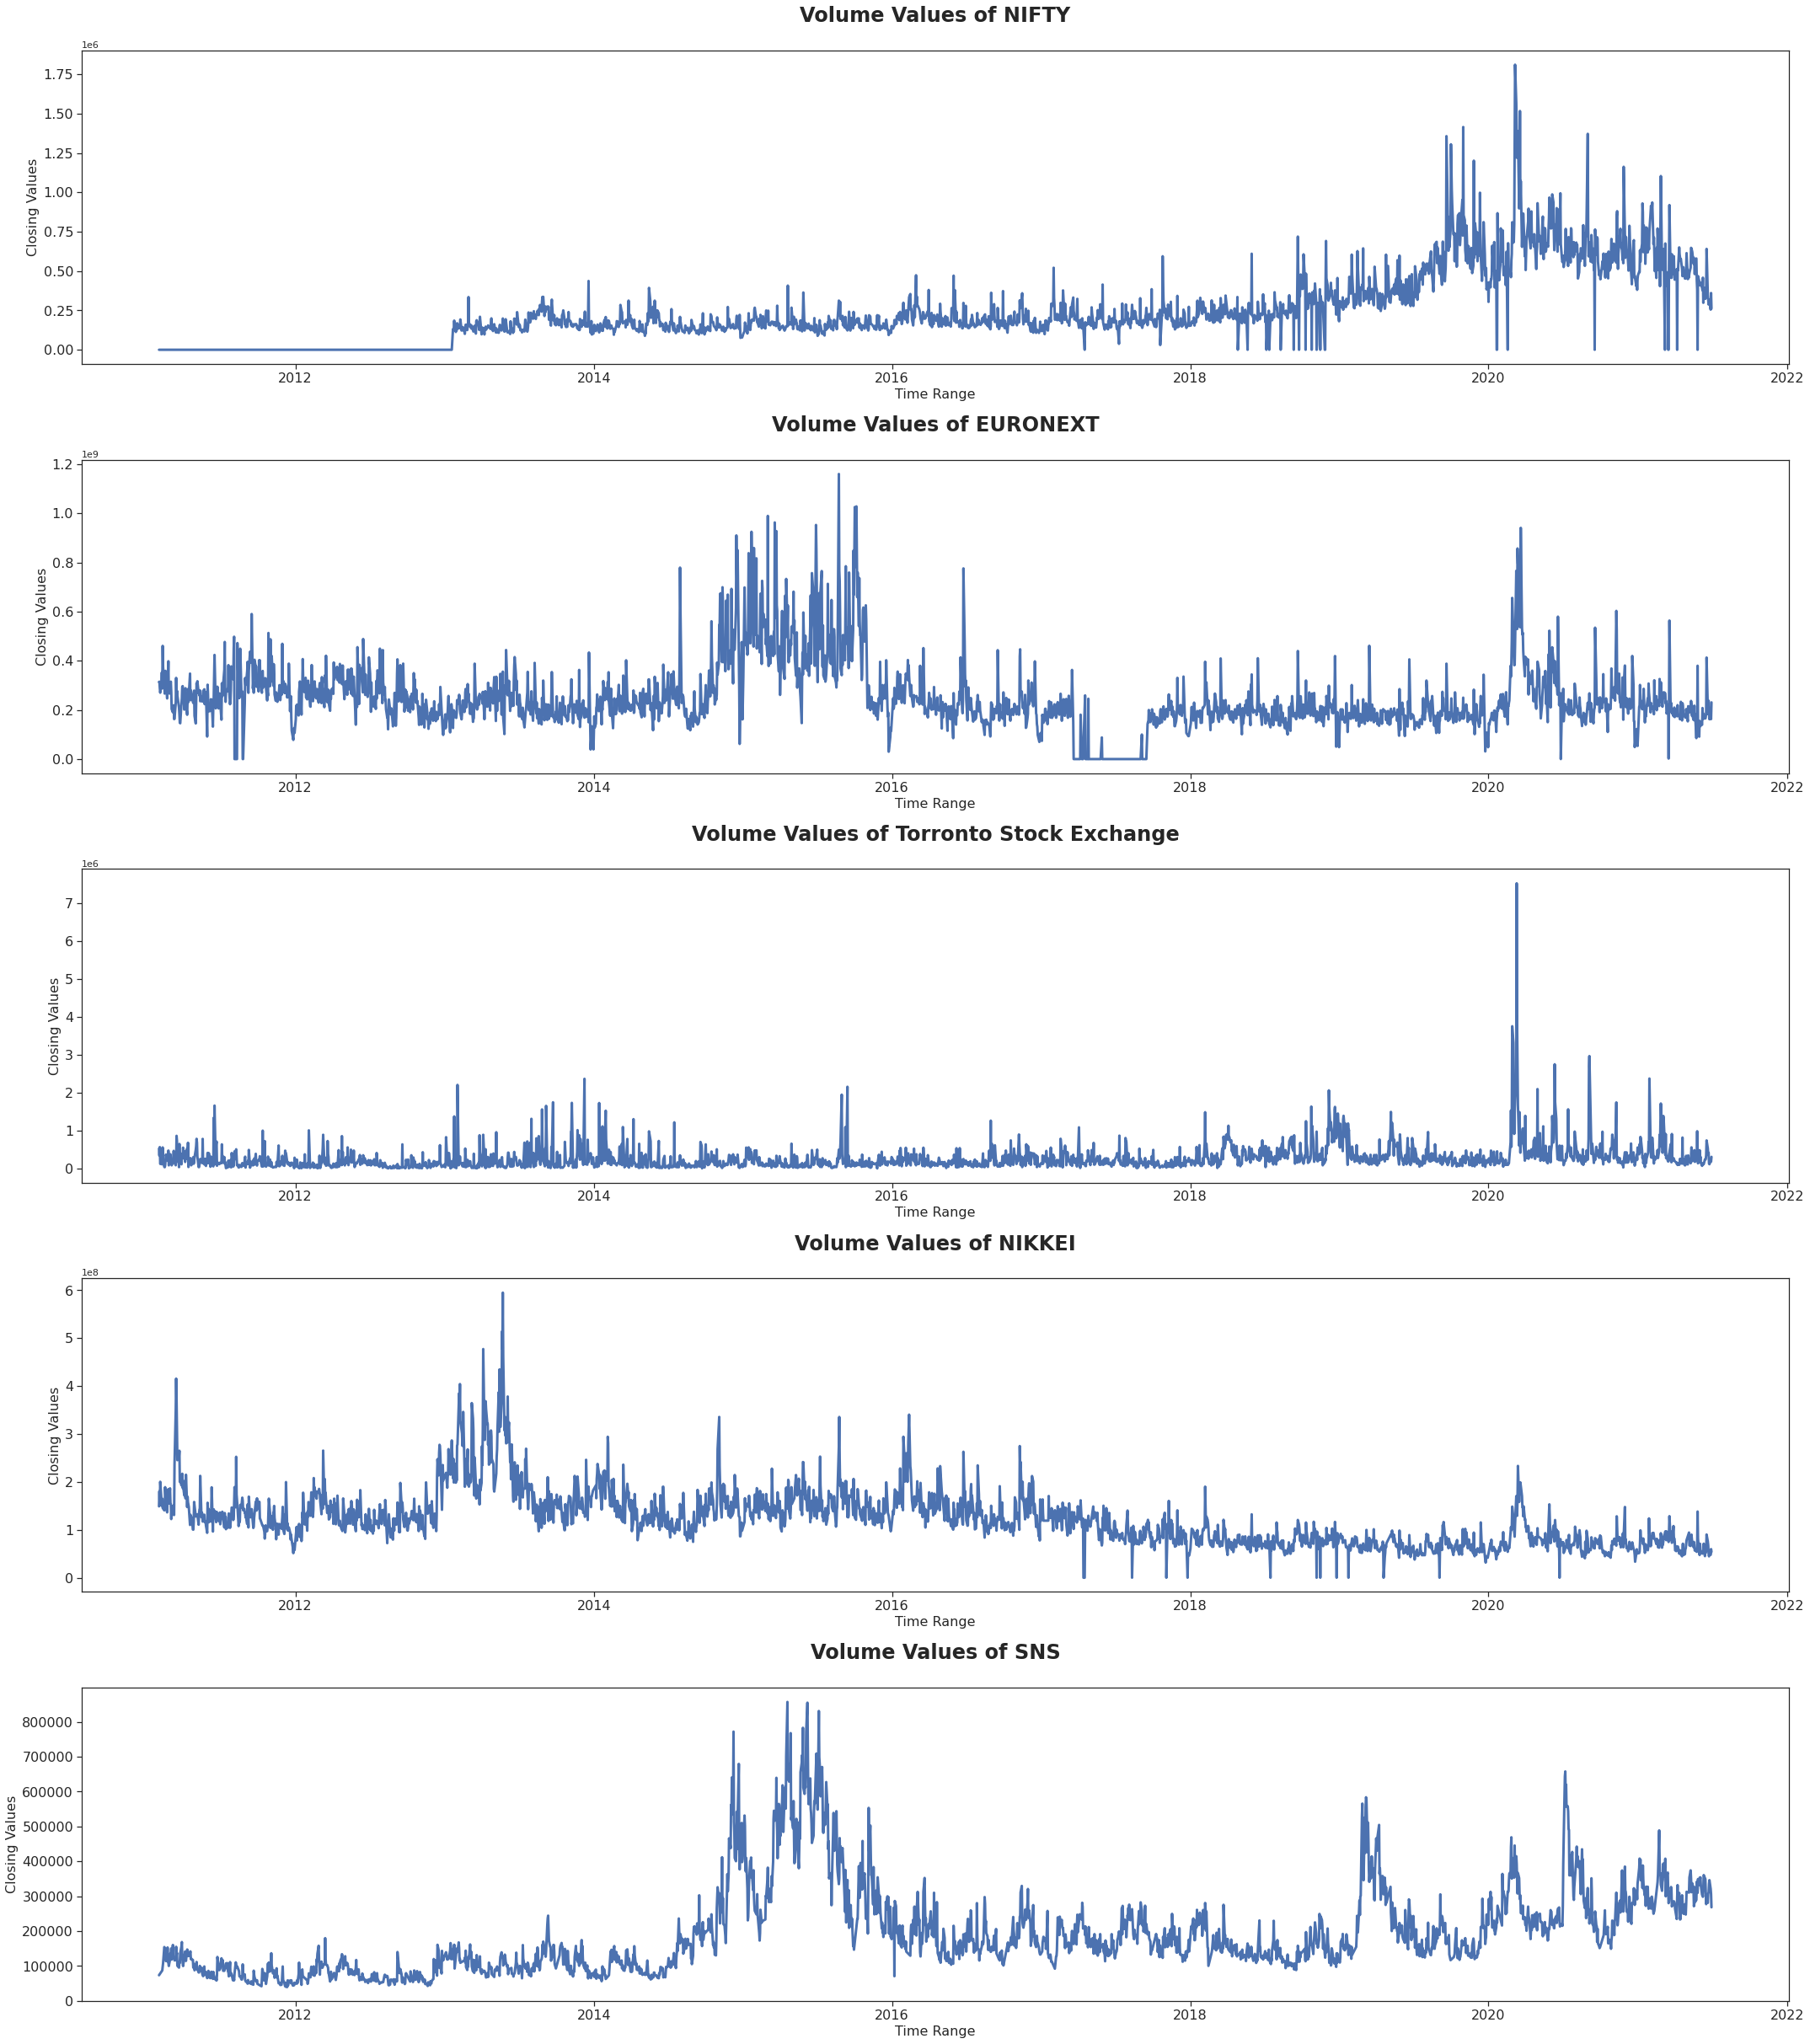

In [ ]:
fig = plt.figure(figsize=(30,40))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i in range(0,len(indexes)-1):
  plot(dfoflist[i], indexes[i],'Volume',i+1)

plt.tight_layout()
plt.savefig('Fig2:Volume.png')
files.download("Fig2:Volume.png") 

In [ ]:
moving_avg = [10, 30, 50]

for ma in moving_avg:
    for df in dfoflist:
        column_name = f"MA for {ma} days"
        df[column_name] = df['Adj Close'].rolling(ma).mean()

def moving_avg_plot(i):
  plt.subplot(6, 1, i+1)
  plt.plot(dfoflist[i]['Date'],dfoflist[i][['Close', 'MA for 10 days', 'MA for 30 days', 'MA for 50 days']])
  plt.legend(dfoflist[i][['Close', 'MA for 10 days', 'MA for 30 days', 'MA for 50 days']],loc = 2,fontsize = 16)
  plt.xlabel('Time Range',fontsize = 16)
  plt.ylabel('Moving Averages',fontsize = 16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.title("Moving Averages for {} \n".format(indexes[i]),fontsize = 24,
            fontweight="bold")

## *Moving Averages for all Indexes*

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

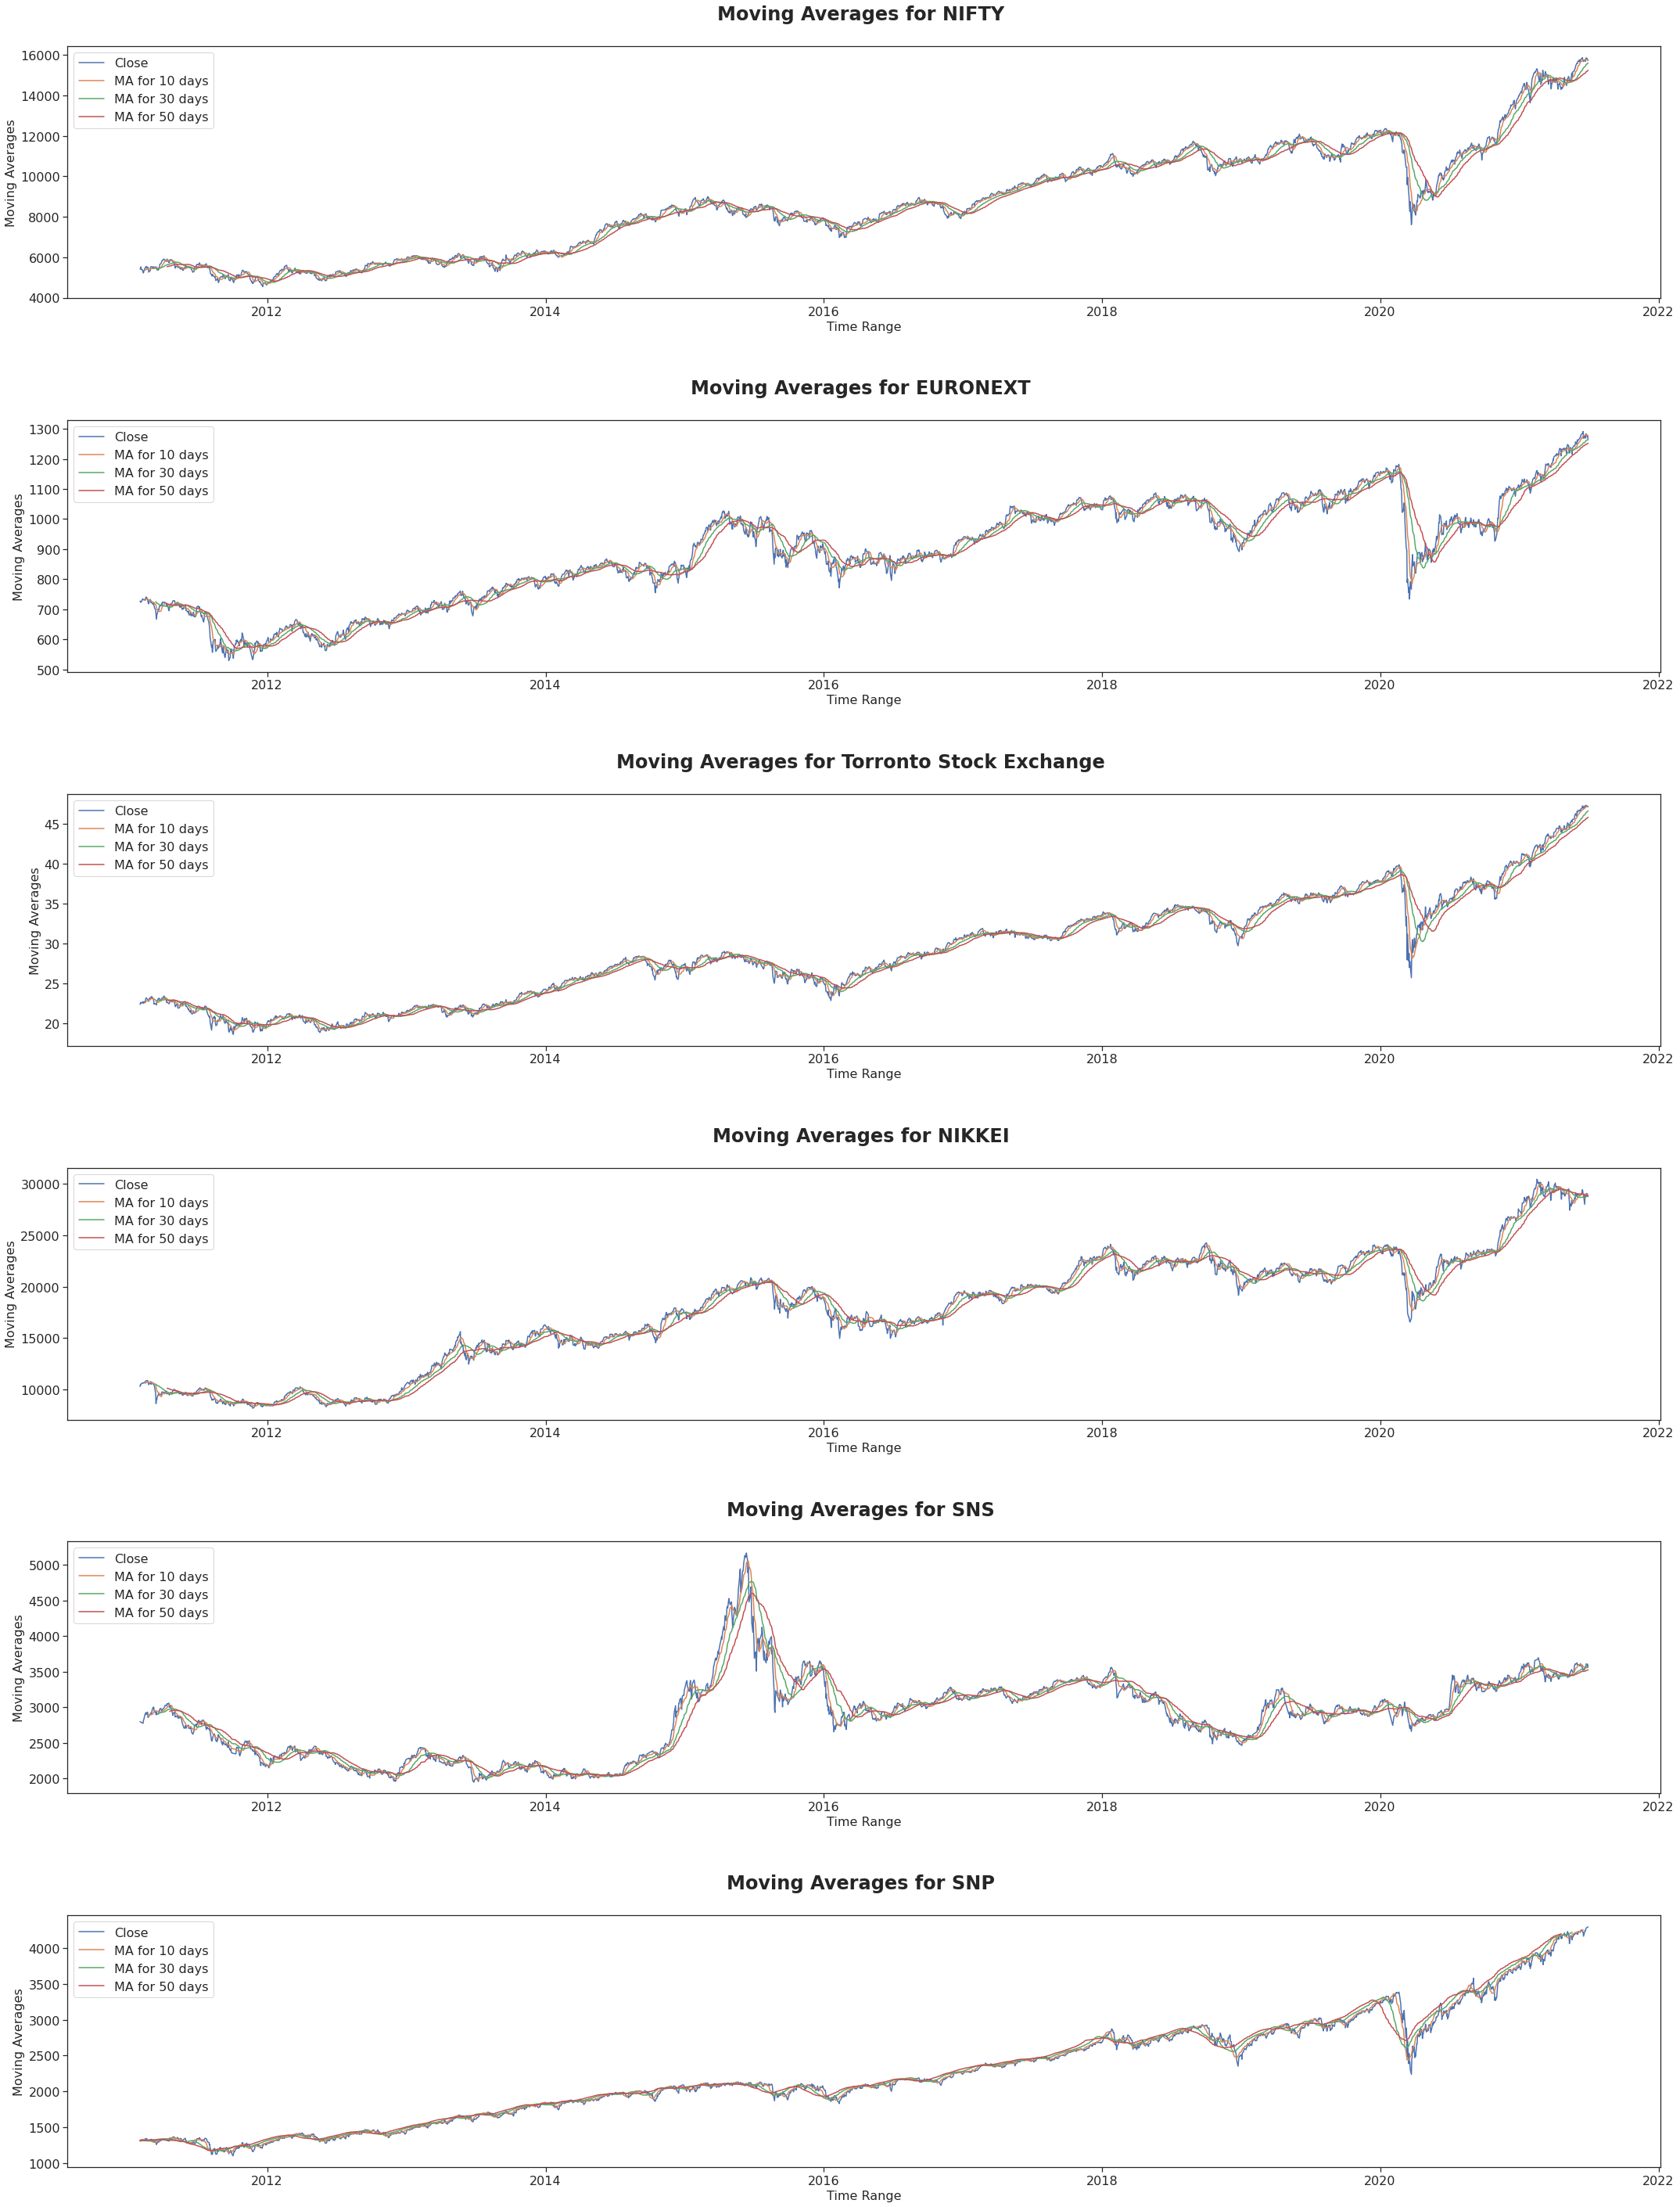

In [ ]:
fig = plt.figure(figsize=(30,40))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i in range(0,len(indexes)):
  moving_avg_plot(i)
plt.tight_layout()
plt.savefig('Fig3:Moving_Average.png')
files.download("Fig3:Moving_Average.png") 

In [ ]:
for df in dfoflist:
  df['Daily Return'] = df['Close'].pct_change()

In [ ]:
def daily_return_plot(i):
  plt.subplot(6, 1, i+1)
  plt.plot(dfoflist[i]['Date'],dfoflist[i]['Daily Return'], color="purple", linestyle="--",linewidth=2)
  plt.legend(dfoflist[i][['Daily Return']],loc = 2,fontsize = 16)
  plt.xlabel('Time Range',fontsize = 16)
  plt.ylabel('Daily Returns',fontsize = 16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.title("Daily Returns for {}\n".format(indexes[i]),fontsize = 24,
            fontweight="bold")

## *Daily Returns for all Indexes*

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

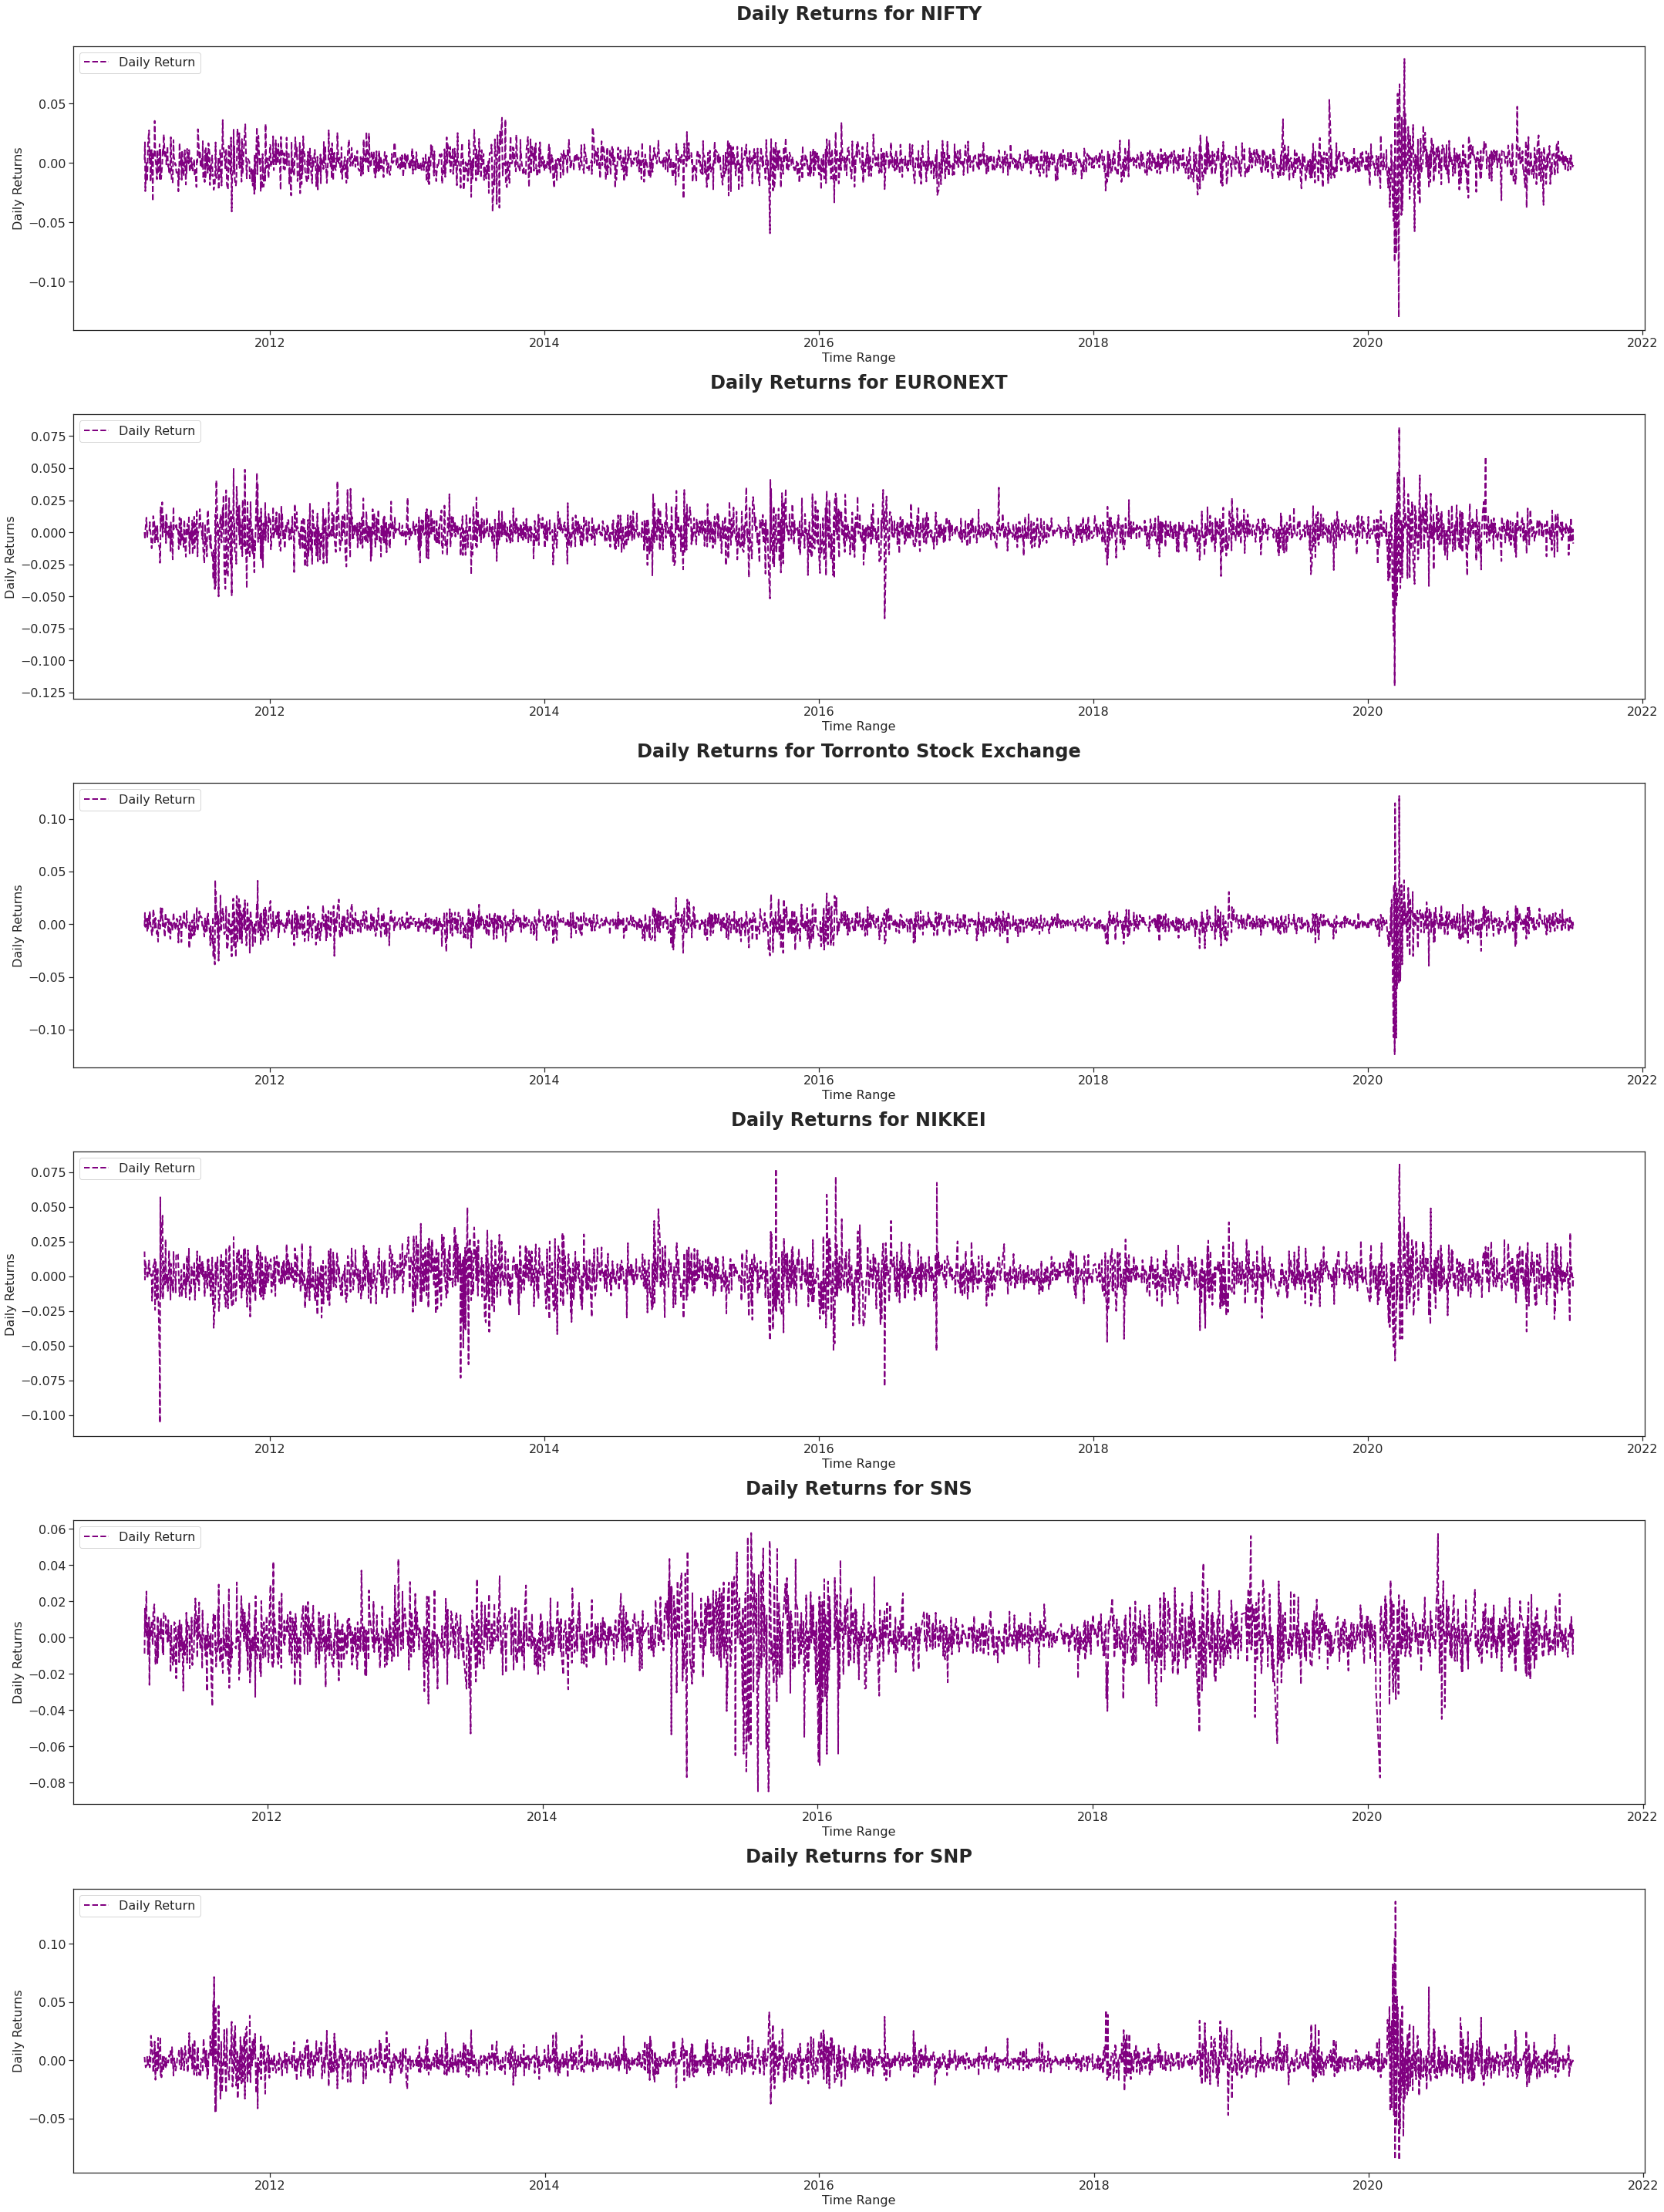

In [ ]:
fig = plt.figure(figsize=(30,40))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i in range(0,len(indexes)):
  daily_return_plot(i)

plt.tight_layout()
plt.savefig('Fig4:Daily_returns.png')
files.download("Fig4:Daily_returns.png") 


# **Analysis Continuation**


---


In [ ]:
dfoflist_copy = []
for d in dfoflist:
  dfoflist_copy.append(d)

dfoflist_copy[0].index = dfoflist_copy[0]["Date"]
dfoflist_copy[1].index = dfoflist_copy[1]["Date"]
dfoflist_copy[2].index = dfoflist_copy[2]["Date"]
dfoflist_copy[3].index = dfoflist_copy[3]["Date"]
dfoflist_copy[4].index = dfoflist_copy[4]["Date"]
dfoflist_copy[5].index = dfoflist_copy[5]["Date"]


In [ ]:
close_df = pd.DataFrame()
close_df['NIFTY'] = dfoflist_copy[0]['Close'] #[dfoflist[0].Date.isin(common)]
close_df['EURONEXT'] = dfoflist_copy[1]['Close'] #[dfoflist[1].Date.isin(common)]
close_df['HXT'] = dfoflist_copy[2]['Close'] #[dfoflist[2].Date.isin(common)]
close_df['NIKKEI'] = dfoflist_copy[3]['Close'] #[dfoflist[3].Date.isin(common)]
close_df['SNS'] = dfoflist_copy[4]['Close'] #[dfoflist[4].Date.isin(common)]
close_df['SNP'] = dfoflist_copy[5]['Close'] #[dfoflist[5].Date.isin(common)]

In [ ]:
close_df[15:].head(5)

NIFTY    EURONEXT  ...          SNS      SNP
Date                                 ...                      
2011-02-22  5469.200195  725.159973  ...  2855.516113  1315.44
2011-02-23  5437.350098  718.940002  ...  2862.635010  1307.40
2011-02-24  5262.700195  717.940002  ...  2878.603027  1306.10
2011-02-25  5303.549805  727.000000  ...  2878.564941  1319.88
2011-02-28  5333.250000  732.809998  ...  2905.052979  1327.22

[5 rows x 6 columns]

In [ ]:
normalized_closedf=(close_df-close_df.min())/(close_df.max()-close_df.min())

In [ ]:
normalized_closedf[15:].head(5)

NIFTY  EURONEXT       HXT    NIKKEI       SNS       SNP
Date                                                                  
2011-02-22  0.081677  0.256836  0.150087  0.112279  0.281533  0.067602
2011-02-23  0.078865  0.248671  0.148691  0.108442  0.283746  0.065088
2011-02-24  0.063443  0.247358  0.143805  0.102776  0.288711  0.064682
2011-02-25  0.067050  0.259251  0.154974  0.106095  0.288699  0.068990
2011-02-28  0.069673  0.266878  0.160558  0.110459  0.296934  0.071285

In [ ]:
tech_rets = close_df.pct_change()
tech_rets.head()

NIFTY  EURONEXT       HXT    NIKKEI  SNS       SNP
Date                                                             
2011-02-01       NaN       NaN       NaN       NaN  NaN       NaN
2011-02-02  0.002732  0.000069 -0.001784  0.017797  0.0 -0.002723
2011-02-03  0.017443 -0.005406  0.010724 -0.002486  0.0  0.002354
2011-02-04 -0.023703  0.000899 -0.002653  0.010752  0.0  0.002884
2011-02-07  0.000046  0.011413  0.000887  0.004602  0.0  0.006240

## *Co - relation Between Each Index*

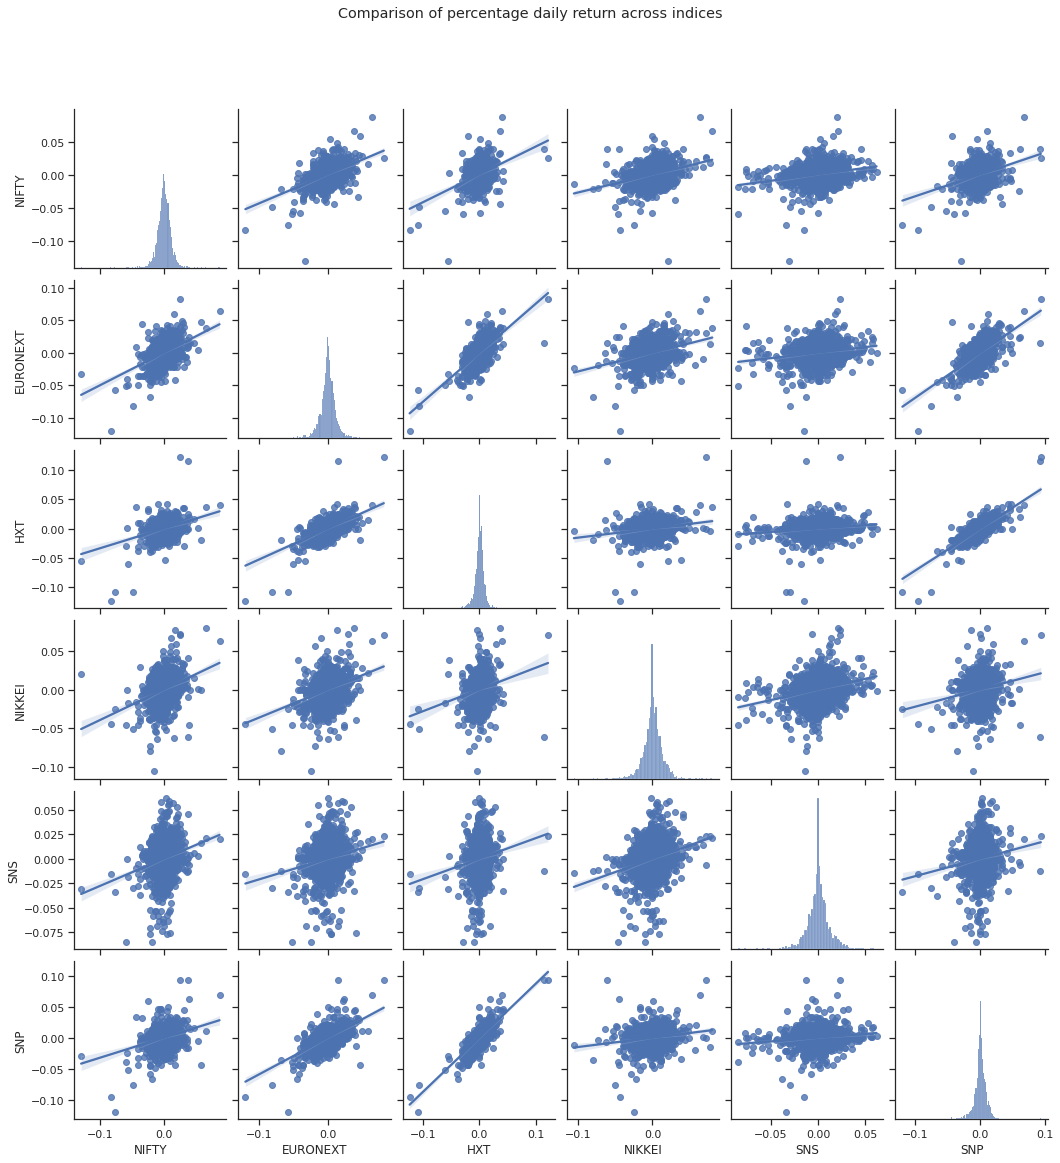

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pp = sns.pairplot(tech_rets, kind='reg')
pp.fig.suptitle("Comparison of percentage daily return across indices", y=1.08)
plt.show()
pp.savefig('Fig5:Comparison_of_percentage_daily_return_across_indices.png')
files.download("Fig5:Comparison_of_percentage_daily_return_across_indices.png") 

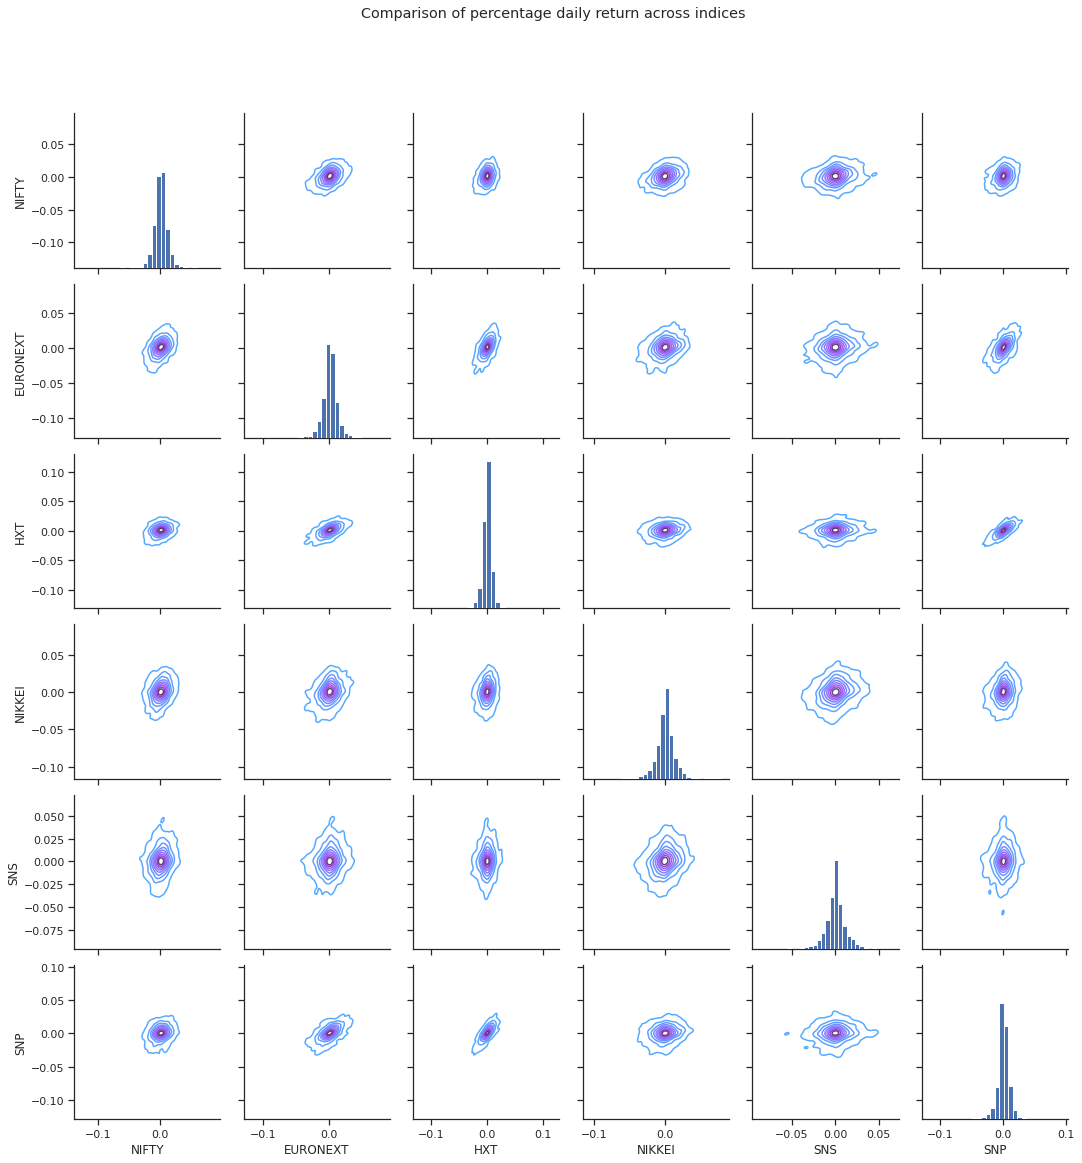

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#
pp2 = sns.PairGrid(tech_rets)
pp2.map_upper(sns.kdeplot, cmap='cool_d')
pp2.map_lower(sns.kdeplot, cmap='cool_d')
pp2.map_diag(plt.hist, bins=30)
pp2.fig.suptitle("Comparison of percentage daily return across indices", y=1.08)
plt.show()

pp2.savefig('FigAmoeba:Comparison_of_percentage_daily_return_across_indices.png')
files.download("FigAmoeba:Comparison_of_percentage_daily_return_across_indices.png") 

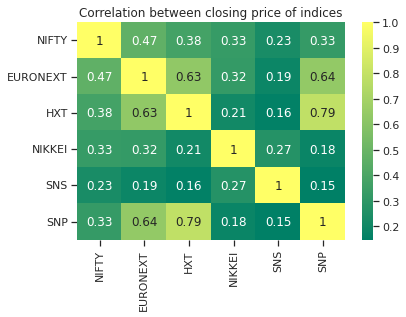

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ax = plt.axes()
hm = sns.heatmap(tech_rets.corr(), annot=True, cmap='summer', ax=ax)
ax.set_title('Correlation between closing price of indices')
plt.show()
fig = hm.get_figure()
fig.savefig('Fig6:Heatmap_showing_correlation_across_indices.png')
files.download("Fig6:Heatmap_showing_correlation_across_indices.png") 

## *Risk vs. Return*

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

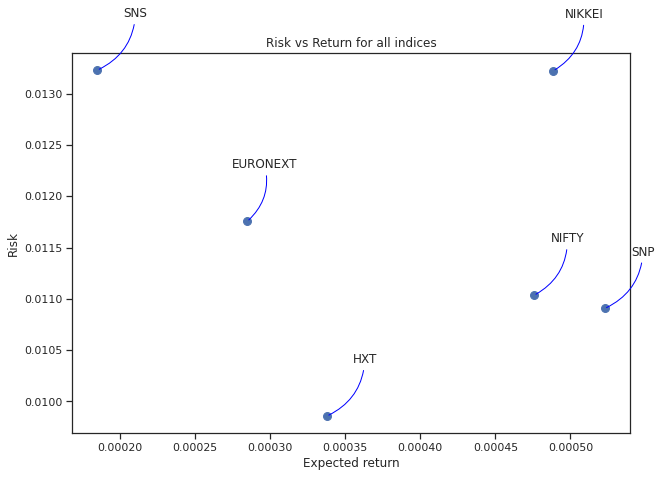

In [ ]:
return_df = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 7))
plt.scatter(return_df.mean(), return_df.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')
plt.title('Risk vs Return for all indices')

for label, x, y in zip(return_df.columns, return_df.mean(), return_df.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

plt.savefig('Fig7:Risk vs Return for all indices.png')
files.download("Fig7:Risk vs Return for all indices.png")

# **Model Comparision**

In [ ]:
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def caculate_score(d):
  data = d.loc[:,['Adj Close','Volume']]
  data['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
  data['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
  # Drop missing value
  data.fillna(value=-99999, inplace=True)
  # We want to separate 1 percent of the data to forecast
  forecast_out = int(math.ceil(0.01 * len(data)))
  # Separating the label here, we want to predict the AdjClose
  forecast_col = 'Adj Close'
  data['label'] = data[forecast_col].shift(-forecast_out)
  X = np.array(data.drop(['label'], 1))
  # Scale the X so that everyone can have the same distribution for linear regression
  X = preprocessing.scale(X)
  # Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
  X_lately = X[-forecast_out:]
  X = X[:-forecast_out]
  # Separate label and identify it as y
  y = np.array(data['label'])
  y = y[:-forecast_out]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # Linear regression
  clfreg = LinearRegression(n_jobs=-1)
  clfreg.fit(X_train, y_train)
  # Quadratic Regression 2
  clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
  clfpoly2.fit(X_train, y_train)

  # Quadratic Regression 3
  clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
  clfpoly3.fit(X_train, y_train)

  # KNN Regression
  clfknn = KNeighborsRegressor(n_neighbors=2)
  clfknn.fit(X_train, y_train)

  #mlp =MLPRegressor(solver='lbfgs')
  #mlp.fit(X_train, y_train)

  confidencereg = clfreg.score(X_test, y_test)
  confidencepoly2 = clfpoly2.score(X_test,y_test)
  confidencepoly3 = clfpoly3.score(X_test,y_test)
  confidenceknn = clfknn.score(X_test, y_test)
  #conf=mlp.score(X_test, y_test)

  print("The linear regression confidence is ",confidencereg)
  print("The quadratic regression 2 confidence is ",confidencepoly2)
  print("The quadratic regression 3 confidence is ",confidencepoly3)
  print("The knn regression confidence is ",confidenceknn)
 # print("The NN confidence is ",conf)

In [ ]:
print("NIFTY:")
caculate_score(dfoflist[0])

NIFTY:
The linear regression confidence is  0.9585354999211406
The quadratic regression 2 confidence is  0.9572201553044553
The quadratic regression 3 confidence is  0.9585586257124526
The knn regression confidence is  0.9578237447750817


In [ ]:
print("EURONEXT:")
caculate_score(dfoflist[1])

EURONEXT:
The linear regression confidence is  0.9291158762173445
The quadratic regression 2 confidence is  0.9273303681631027
The quadratic regression 3 confidence is  0.9267050158065138
The knn regression confidence is  0.9187830908609773


In [ ]:
print("TORRONTO STOCK EXCHANGE:")
caculate_score(dfoflist[2])

TORRONTO STOCK EXCHANGE:
The linear regression confidence is  0.9622173522853951
The quadratic regression 2 confidence is  0.9614559658202287
The quadratic regression 3 confidence is  0.9602179027119473
The knn regression confidence is  0.9575642659969383


In [ ]:
print("NIKKEI:")
caculate_score(dfoflist[3])

NIKKEI:
The linear regression confidence is  0.9576724485327534
The quadratic regression 2 confidence is  0.9583384993664621
The quadratic regression 3 confidence is  0.9578149673974068
The knn regression confidence is  0.9529768614936649


In [ ]:
print("SNS:")
caculate_score(dfoflist[4])

SNS:
The linear regression confidence is  0.7655931977319121
The quadratic regression 2 confidence is  0.8054231455830139
The quadratic regression 3 confidence is  0.8000364991336739
The knn regression confidence is  0.8314466808129177


# **Phase - II Prediction**

# **FB Prophet**

## *Defining Functions*

In [ ]:
def FB_Prophets_1(data,period):
  fbprop = Prophet(daily_seasonality=True)
  FB_data = data[["Date","Close"]]
  FB_data = FB_data.rename(columns={"Date": "ds", "Close": "y"})
  fbprop.fit(FB_data)
  future = fbprop.make_future_dataframe(periods=period)
  forecast = fbprop.predict(future)
  return fbprop,forecast

In [ ]:
def FB_Prophets(data,period):
  data = data.sort_index()

  test_ratio = 0.2
  training_ratio = 1 - test_ratio

  train_size = int(training_ratio * len(data))
  test_size = int(test_ratio * len(data))
  print("train_size: " + str(train_size))
  print("test_size: " + str(test_size))

  train = data[:train_size][['Date', 'Close']]
  test = data[train_size:][['Date', 'Close']]

  fbprop = Prophet(daily_seasonality=True)
  FB_data = train[["Date","Close"]]
  FB_data = FB_data.rename(columns={"Date": "ds", "Close": "y"})
  fbprop.fit(FB_data)

  forecast = fbprop.predict(test.rename(columns={"Date": "ds", "Close": "y"})["ds"].to_frame())

  rmse = calculate_rmse(np.array(test["Close"]),np.array(forecast["yhat"]))
  mape = calculate_mape(np.array(test["Close"]),np.array(forecast["yhat"]))

  return fbprop,forecast,rmse,mape,test,train

In [ ]:
def FB_Prophets_CV(fbprop):
  df_cv = cross_validation(fbprop, initial='1460 days', period='365 days', horizon = '730 days')
  print(df_cv)
  df_p = performance_metrics(df_cv)
  print(df_p)
  fig = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
def plot_stock_trend_FBP(train, test):        
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['Date'], train['Close'], label = 'Train Closing Price')
    plt.plot(test['Date'], test['Close'], label = 'Test Closing Price')
    plt.plot(test['Date'], test['Predictions_FB'], label = 'Predicted Closing Price')
    plt.title('FBProphet Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")

In [ ]:
def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                
    return rmse

def calculate_mape(y_true, y_pred): 
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100   
    return mape

## *NIFTY*

In [ ]:
fbprop,forecast,rmse,mape,test,train = FB_Prophets(dfoflist[0],730)

train_size: 2056
test_size: 514


In [ ]:
tprint(indexes[0].upper())
plot_plotly(fbprop, forecast)

 _   _  ___  _____  _____ __   __
| \ | ||_ _||  ___||_   _|\ \ / /
|  \| | | | | |_     | |   \ V / 
| |\  | | | |  _|    | |    | |  
|_| \_||___||_|      |_|    |_|  
                                 



RSME SMA:  1637.5435022591269
MAPE SMA: 11.150270768632113


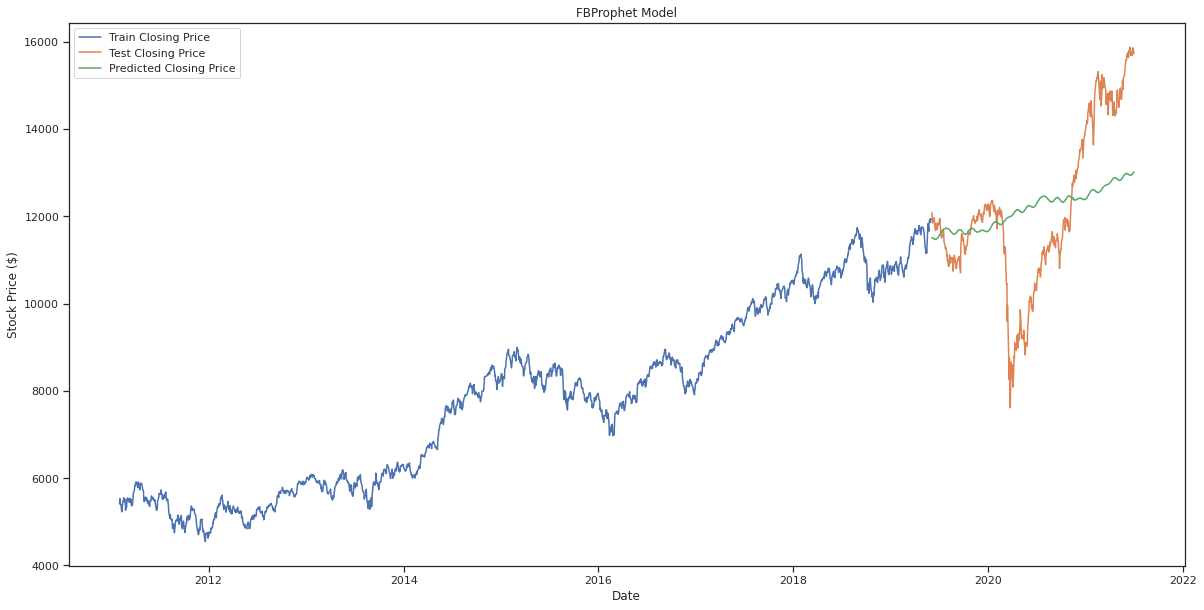

In [ ]:
test['Predictions_FB'] = np.array(forecast["yhat"])

plot_stock_trend_FBP(train,test)
print("RSME SMA: ", rmse)
print("MAPE SMA:", mape)

INFO:prophet:Making 3 forecasts with cutoffs between 2015-06-01 00:00:00 and 2017-05-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

             ds          yhat  ...             y     cutoff
0    2015-06-02   8513.076334  ...   8236.450195 2015-06-01
1    2015-06-03   8517.781311  ...   8135.100098 2015-06-01
2    2015-06-04   8517.997556  ...   8130.649902 2015-06-01
3    2015-06-05   8519.520513  ...   8114.700195 2015-06-01
4    2015-06-08   8503.399189  ...   8044.149902 2015-06-01
...         ...           ...  ...           ...        ...
1477 2019-05-27  12047.725358  ...  11924.750000 2017-05-31
1478 2019-05-28  12052.606054  ...  11928.750000 2017-05-31
1479 2019-05-29  12065.835349  ...  11861.099609 2017-05-31
1480 2019-05-30  12072.960551  ...  11945.900391 2017-05-31
1481 2019-05-31  12077.759118  ...  11922.799805 2017-05-31

[1482 rows x 6 columns]
     horizon           mse         rmse  ...     mdape     smape  coverage
0    70 days  3.455642e+05   587.847124  ...  0.029349  0.053651  0.439189
1    71 days  3.536408e+05   594.677060  ...  0.029170  0.053974  0.445946
2    72 days  3.613079e+05   6

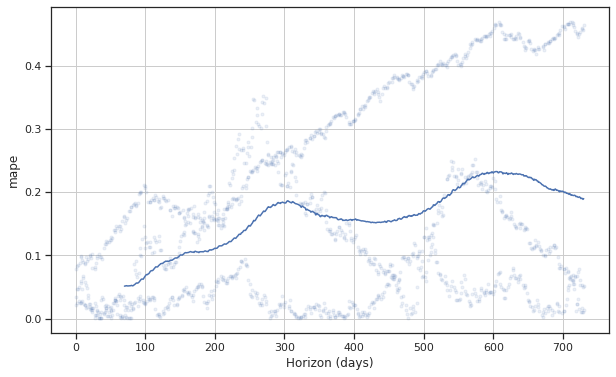

In [ ]:
FB_Prophets_CV(fbprop)

## *EURONEXT*

In [ ]:
fbprop,forecast,rmse,mape,test,train = FB_Prophets(dfoflist[1],730)

train_size: 2129
test_size: 532


In [ ]:
tprint(indexes[1].upper())

plot_plotly(fbprop, forecast)

 _____  _   _  ____    ___   _   _  _____ __  __ _____ 
| ____|| | | ||  _ \  / _ \ | \ | || ____|\ \/ /|_   _|
|  _|  | | | || |_) || | | ||  \| ||  _|   \  /   | |  
| |___ | |_| ||  _ < | |_| || |\  || |___  /  \   | |  
|_____| \___/ |_| \_\ \___/ |_| \_||_____|/_/\_\  |_|  
                                                       



RSME SMA:  146.74938979310733
MAPE SMA: 11.013610514277088


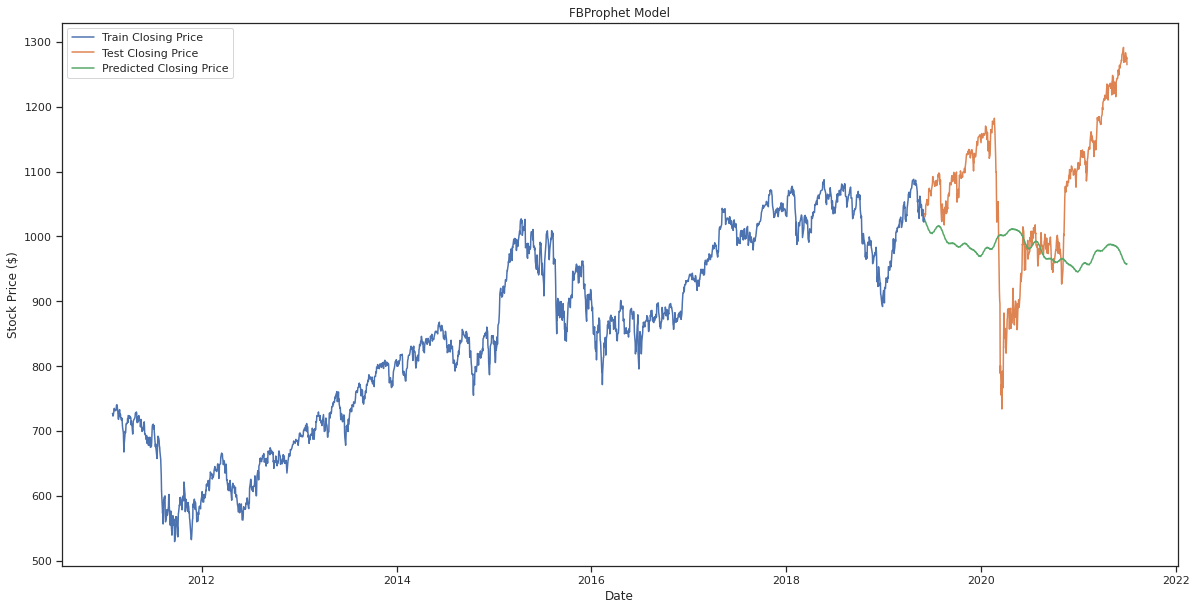

In [ ]:
test['Predictions_FB'] = np.array(forecast["yhat"])

plot_stock_trend_FBP(train,test)
print("RSME SMA: ", rmse)
print("MAPE SMA:", mape)

INFO:prophet:Making 3 forecasts with cutoffs between 2015-06-04 00:00:00 and 2017-06-03 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

             ds         yhat  yhat_lower   yhat_upper            y     cutoff
0    2015-06-05  1003.799236  979.857891  1028.350927   961.289978 2015-06-04
1    2015-06-08  1002.154994  978.219798  1026.123947   951.200012 2015-06-04
2    2015-06-09  1002.505204  979.372120  1024.888090   949.250000 2015-06-04
3    2015-06-10  1002.224492  979.443863  1025.622250   964.650024 2015-06-04
4    2015-06-11  1003.046759  979.774832  1026.823450   971.390015 2015-06-04
...         ...          ...         ...          ...          ...        ...
1526 2019-05-28  1240.016858  733.227263  1730.078293  1038.910034 2017-06-03
1527 2019-05-29  1239.769804  732.899046  1744.030334  1022.989990 2017-06-03
1528 2019-05-30  1239.612082  738.119882  1744.204744  1030.750000 2017-06-03
1529 2019-05-31  1238.976868  719.617619  1738.686425  1022.090027 2017-06-03
1530 2019-06-03  1234.949609  716.378788  1743.982868  1026.260010 2017-06-03

[1531 rows x 6 columns]
     horizon            mse        rmse

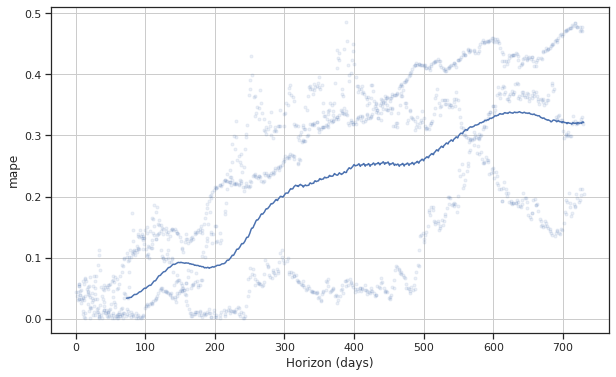

In [ ]:
FB_Prophets_CV(fbprop)

## *HXT*

In [ ]:
fbprop,forecast,rmse,mape,test,train = FB_Prophets(dfoflist[2],730)

train_size: 2091
test_size: 522


In [ ]:
tprint(indexes[2].upper())

plot_plotly(fbprop, forecast)

 _____   ___   ____   ____    ___   _   _  _____   ___    ____   _____   ___    ____  _  __  _____ __  __  ____  _   _     _     _   _   ____  _____ 
|_   _| / _ \ |  _ \ |  _ \  / _ \ | \ | ||_   _| / _ \  / ___| |_   _| / _ \  / ___|| |/ / | ____|\ \/ / / ___|| | | |   / \   | \ | | / ___|| ____|
  | |  | | | || |_) || |_) || | | ||  \| |  | |  | | | | \___ \   | |  | | | || |    | ' /  |  _|   \  / | |    | |_| |  / _ \  |  \| || |  _ |  _|  
  | |  | |_| ||  _ < |  _ < | |_| || |\  |  | |  | |_| |  ___) |  | |  | |_| || |___ | . \  | |___  /  \ | |___ |  _  | / ___ \ | |\  || |_| || |___ 
  |_|   \___/ |_| \_\|_| \_\ \___/ |_| \_|  |_|   \___/  |____/   |_|   \___/  \____||_|\_\ |_____|/_/\_\ \____||_| |_|/_/   \_\|_| \_| \____||_____|
                                                                                                                                                     



RSME SMA:  3.9243886923359823
MAPE SMA: 7.903118354048036


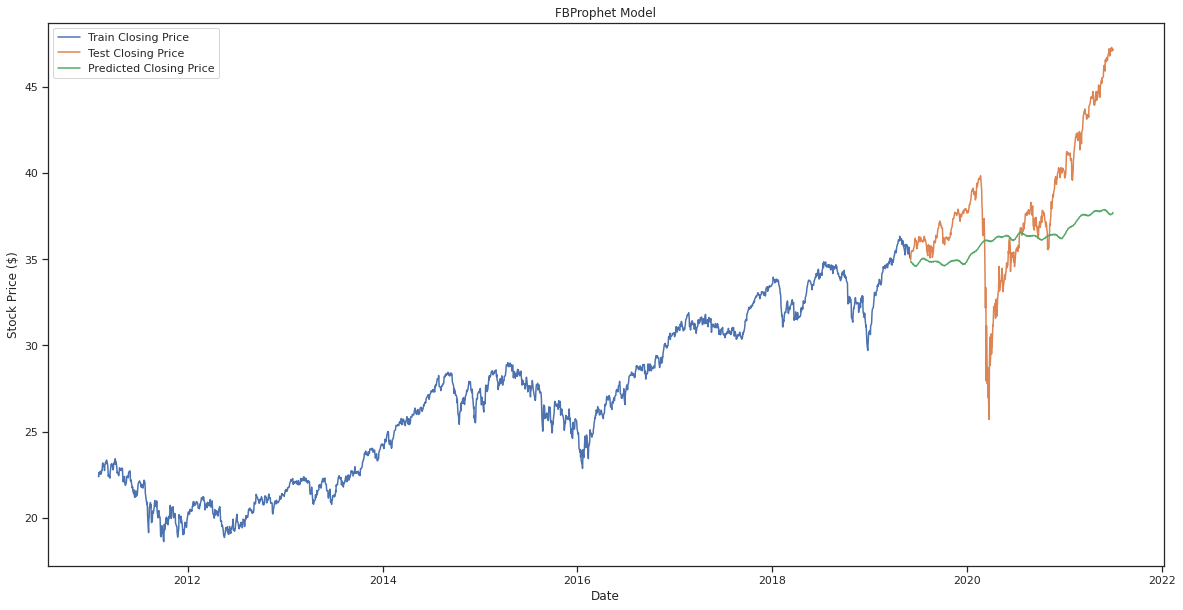

In [ ]:
test['Predictions_FB'] = np.array(forecast["yhat"])

plot_stock_trend_FBP(train,test)
print("RSME SMA: ", rmse)
print("MAPE SMA:", mape)

INFO:prophet:Making 3 forecasts with cutoffs between 2015-06-01 00:00:00 and 2017-05-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

             ds       yhat  yhat_lower  yhat_upper          y     cutoff
0    2015-06-02  28.424345   27.971073   28.897308  28.350000 2015-06-01
1    2015-06-03  28.417044   27.923776   28.901422  28.500000 2015-06-01
2    2015-06-04  28.418461   27.944617   28.883551  28.260000 2015-06-01
3    2015-06-05  28.423693   27.932468   28.898626  28.150000 2015-06-01
4    2015-06-08  28.383439   27.918928   28.857806  27.690001 2015-06-01
...         ...        ...         ...         ...        ...        ...
1501 2019-05-27  43.436530   30.064795   58.024555  35.689999 2017-05-31
1502 2019-05-28  43.482442   29.892794   57.680148  35.520000 2017-05-31
1503 2019-05-29  43.518183   29.792276   58.207932  35.250000 2017-05-31
1504 2019-05-30  43.551983   29.760865   58.141099  35.169998 2017-05-31
1505 2019-05-31  43.574356   29.865768   58.147568  35.060001 2017-05-31

[1506 rows x 6 columns]
     horizon        mse      rmse  ...     mdape     smape  coverage
0    72 days   4.580669  2.140

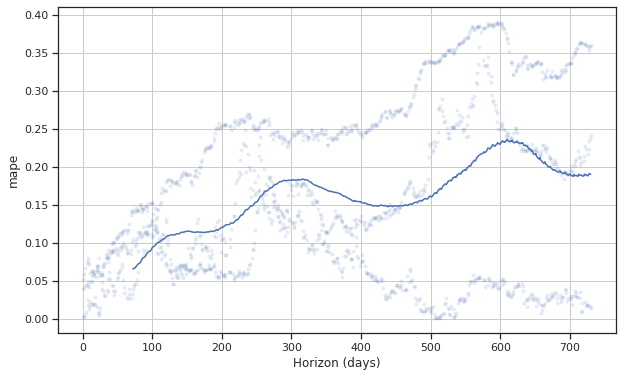

In [ ]:
FB_Prophets_CV(fbprop)

## *NIKKEI*

In [ ]:
fbprop,forecast,rmse,mape,test,train = FB_Prophets(dfoflist[3],730)

train_size: 2056
test_size: 514


In [ ]:
tprint(indexes[3].upper())

plot_plotly(fbprop, forecast)

 _   _  ___  _  __ _  __ _____  ___ 
| \ | ||_ _|| |/ /| |/ /| ____||_ _|
|  \| | | | | ' / | ' / |  _|   | | 
| |\  | | | | . \ | . \ | |___  | | 
|_| \_||___||_|\_\|_|\_\|_____||___|
                                    



RSME SMA:  4037.097004749927
MAPE SMA: 11.673196010666755


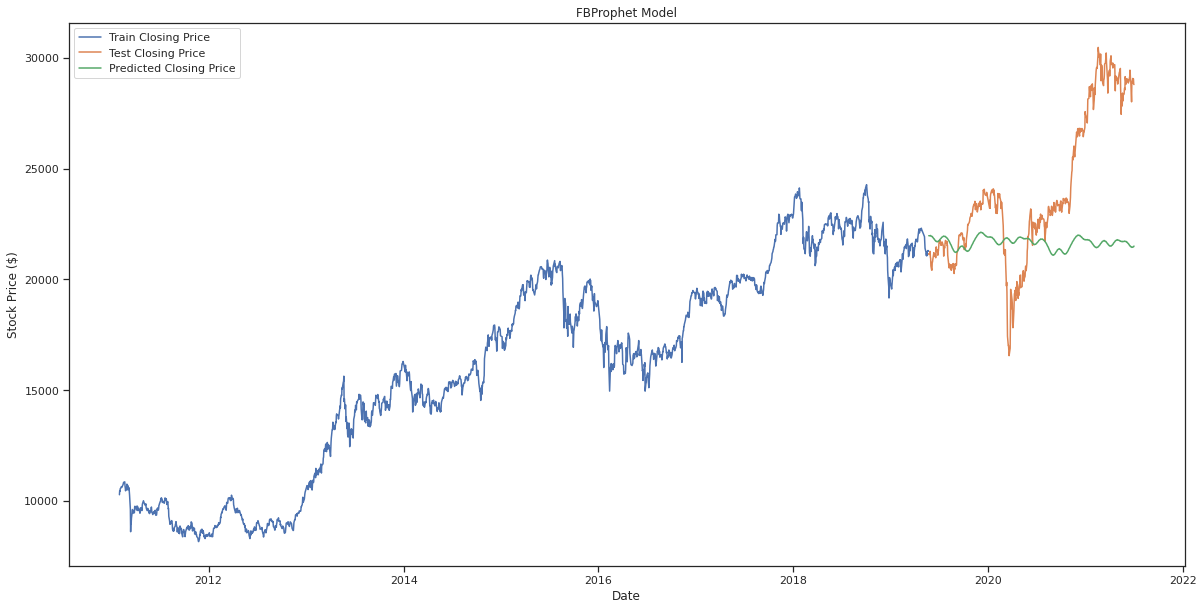

In [ ]:
test['Predictions_FB'] = np.array(forecast["yhat"])

plot_stock_trend_FBP(train,test)
print("RSME SMA: ", rmse)
print("MAPE SMA:", mape)

INFO:prophet:Making 3 forecasts with cutoffs between 2015-05-23 00:00:00 and 2017-05-22 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

             ds          yhat  ...             y     cutoff
0    2015-05-25  19996.179871  ...  20413.769531 2015-05-23
1    2015-05-26  19989.026793  ...  20437.480469 2015-05-23
2    2015-05-27  20001.762345  ...  20472.580078 2015-05-23
3    2015-05-28  19979.084581  ...  20551.460938 2015-05-23
4    2015-05-29  19984.613631  ...  20563.150391 2015-05-23
...         ...           ...  ...           ...        ...
1501 2019-05-16  24649.722267  ...  21062.980469 2017-05-22
1502 2019-05-17  24654.500427  ...  21250.089844 2017-05-22
1503 2019-05-20  24651.934677  ...  21301.730469 2017-05-22
1504 2019-05-21  24654.185443  ...  21272.449219 2017-05-22
1505 2019-05-22  24673.406961  ...  21283.369141 2017-05-22

[1506 rows x 6 columns]
     horizon           mse          rmse  ...     mdape     smape  coverage
0    71 days  3.576273e+05    598.019449  ...  0.026692  0.028093  0.640000
1    72 days  3.586815e+05    598.900260  ...  0.026692  0.028192  0.640000
2    73 days  3.577607e+05 

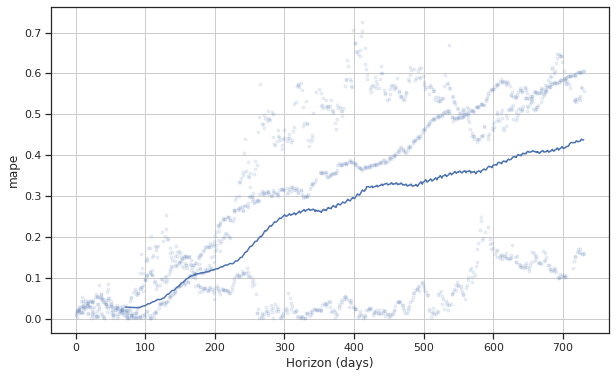

In [ ]:
FB_Prophets_CV(fbprop)

## *SNS*

In [ ]:
fbprop,forecast,rmse,mape,test,train = FB_Prophets(dfoflist[4],730)

train_size: 2022
test_size: 505


In [ ]:
tprint(indexes[4].upper())

plot_plotly(fbprop, forecast)

 ____   _   _  ____  
/ ___| | \ | |/ ___| 
\___ \ |  \| |\___ \ 
 ___) || |\  | ___) |
|____/ |_| \_||____/ 
                     



RSME SMA:  1093.6719683540687
MAPE SMA: 29.685795520286074


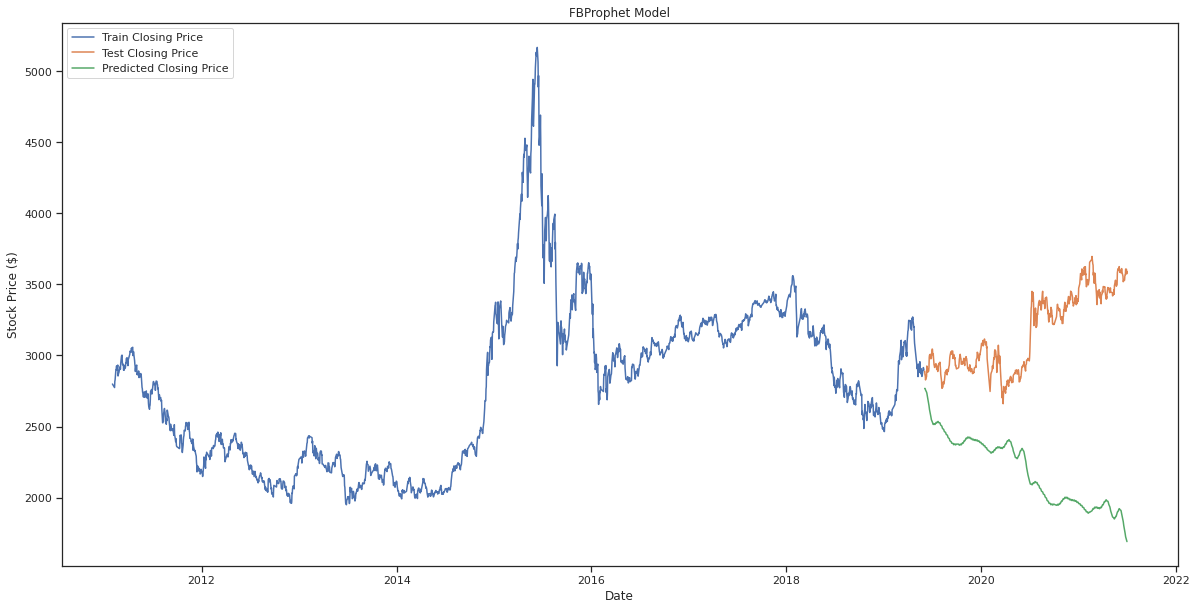

In [ ]:
test['Predictions_FB'] = np.array(forecast["yhat"])

plot_stock_trend_FBP(train,test)
print("RSME SMA: ", rmse)
print("MAPE SMA:", mape)

INFO:prophet:Making 3 forecasts with cutoffs between 2015-06-01 00:00:00 and 2017-05-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

             ds         yhat   yhat_lower   yhat_upper            y     cutoff
0    2015-06-02  4451.799858  4326.101964  4577.998110  4910.526855 2015-06-01
1    2015-06-03  4456.197170  4330.797074  4575.077959  4909.978027 2015-06-01
2    2015-06-04  4451.760231  4321.368585  4579.954325  4947.102051 2015-06-01
3    2015-06-05  4457.152514  4335.811627  4581.919254  5023.096191 2015-06-01
4    2015-06-08  4463.701294  4338.250596  4587.880293  5131.880859 2015-06-01
...         ...          ...          ...          ...          ...        ...
1455 2019-05-27  3785.605255   963.157680  6462.551257  2892.377930 2017-05-31
1456 2019-05-28  3797.383990   949.283202  6446.825246  2909.910889 2017-05-31
1457 2019-05-29  3808.721657   891.605729  6630.031722  2914.696045 2017-05-31
1458 2019-05-30  3815.909311   985.897388  6536.442699  2905.804932 2017-05-31
1459 2019-05-31  3826.123105   916.492378  6588.284181  2898.696045 2017-05-31

[1460 rows x 6 columns]
     horizon           mse 

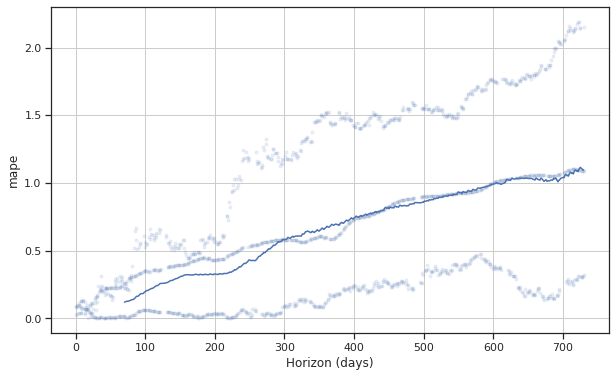

In [ ]:
FB_Prophets_CV(fbprop)

## *SNP*

In [ ]:
fbprop,forecast,rmse,mape,test,train = FB_Prophets(dfoflist[5],730)

train_size: 2096
test_size: 524


In [ ]:
tprint(indexes[5].upper())

plot_plotly(fbprop, forecast)

 ____   _   _  ____  
/ ___| | \ | ||  _ \ 
\___ \ |  \| || |_) |
 ___) || |\  ||  __/ 
|____/ |_| \_||_|    
                     



RSME SMA:  530.2187965194616
MAPE SMA: 11.457094999238153


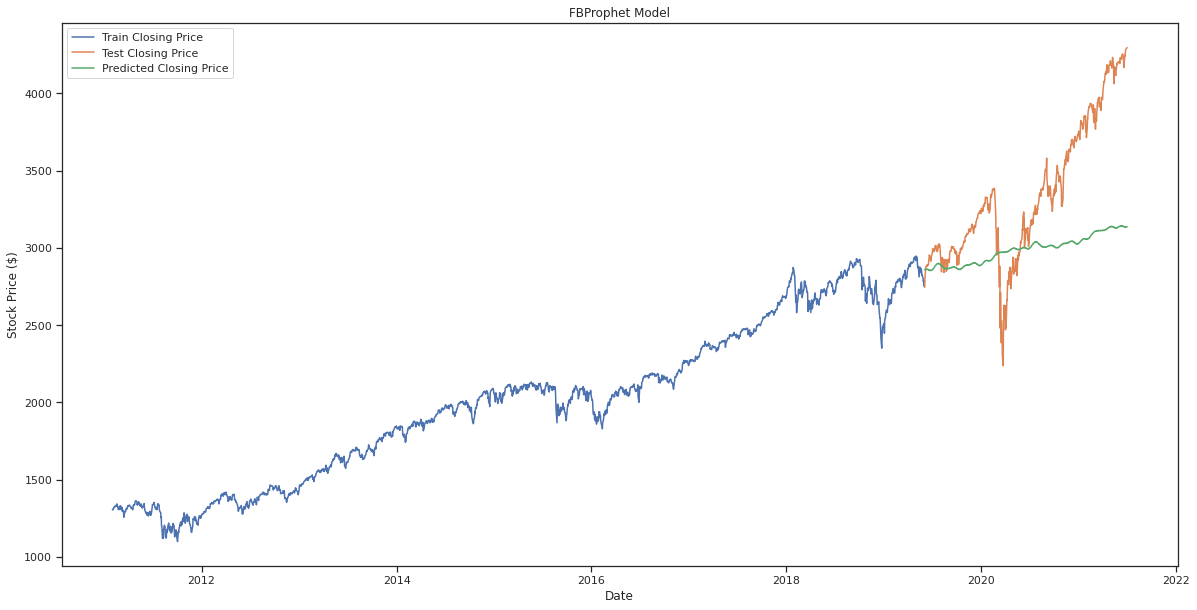

In [ ]:
test['Predictions_FB'] = np.array(forecast["yhat"])

plot_stock_trend_FBP(train,test)
print("RSME SMA: ", rmse)
print("MAPE SMA:", mape)

INFO:prophet:Making 3 forecasts with cutoffs between 2015-06-01 00:00:00 and 2017-05-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

             ds         yhat   yhat_lower   yhat_upper        y     cutoff
0    2015-06-02  2114.853926  2079.167222  2147.453404  2109.60 2015-06-01
1    2015-06-03  2113.294338  2077.902309  2144.567433  2114.07 2015-06-01
2    2015-06-04  2114.713272  2080.677878  2147.078960  2095.84 2015-06-01
3    2015-06-05  2115.371915  2080.240679  2150.450990  2092.83 2015-06-01
4    2015-06-08  2113.089968  2080.970023  2147.316533  2079.28 2015-06-01
...         ...          ...          ...          ...      ...        ...
1506 2019-05-24  3090.103114  2526.042105  3707.576346  2826.06 2017-05-31
1507 2019-05-28  3094.082540  2532.508674  3705.438351  2802.39 2017-05-31
1508 2019-05-29  3094.696264  2535.746189  3708.907603  2783.02 2017-05-31
1509 2019-05-30  3096.590628  2529.633251  3712.088992  2788.86 2017-05-31
1510 2019-05-31  3097.306933  2532.599456  3707.495986  2752.06 2017-05-31

[1511 rows x 6 columns]
     horizon            mse        rmse  ...     mdape     smape  coverage


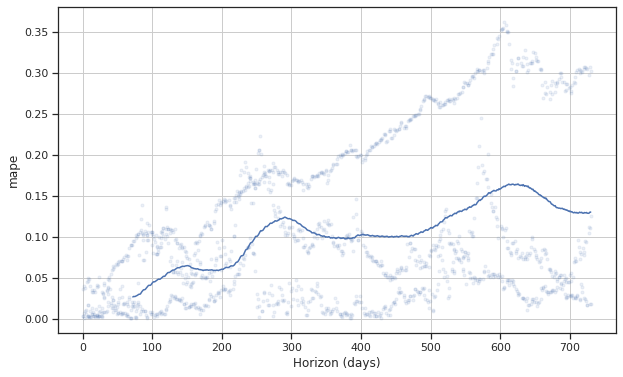

In [ ]:
FB_Prophets_CV(fbprop)

# **Phase - 2 SME, EME, LSTM**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import StandardScaler
from keras.layers import Input
from keras.layers import LSTM
from keras.models import Model

from sklearn.preprocessing import MinMaxScaler

In [ ]:
# stockprices=pd.read_csv('/content/nifty50.csv')
stockprices = dfoflist[0]
stockprices = stockprices.sort_index()
stockprices.head()
stockprices.dropna(subset=['Close'], how='all', inplace=True)

test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print("train_size: " + str(train_size))
print("test_size: " + str(test_size))

train = stockprices[:train_size][['Date', 'Close']]
test = stockprices[train_size:][['Date', 'Close']]

train_size: 2056
test_size: 514


In [ ]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset 
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []
    
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)

In [ ]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                
    return rmse

def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100   
    return mape

In [ ]:
def calculate_perf_metrics(var, logNeptune=False, logmodelName='Simple MA'):
    ### RMSE 
    rmse = calculate_rmse(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:][var]))
    ### MAPE 
    mape = calculate_mape(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:][var]))
    
    if logNeptune:        
        npt_exp.send_metric('RMSE', rmse)
        npt_exp.log_metric('RMSE', rmse)
        
        npt_exp.send_metric('MAPE (%)', mape)
        npt_exp.log_metric('MAPE (%)', mape)
    
    return rmse, mape

In [ ]:
def plot_stock_trend(var, cur_title, stockprices=stockprices, logNeptune=False, logmodelName='Simple MA'):
    ax = stockprices[['Close', var,'200day']].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis('tight')
    plt.ylabel('Stock Price ($)')
    
    if logNeptune:
        npt_exp.log_image(f'Plot of Stock Predictions with {logmodelName}', ax.get_figure())

RSME SMA:  794.1738555612911
MAPE SMA: 5.184578163954257


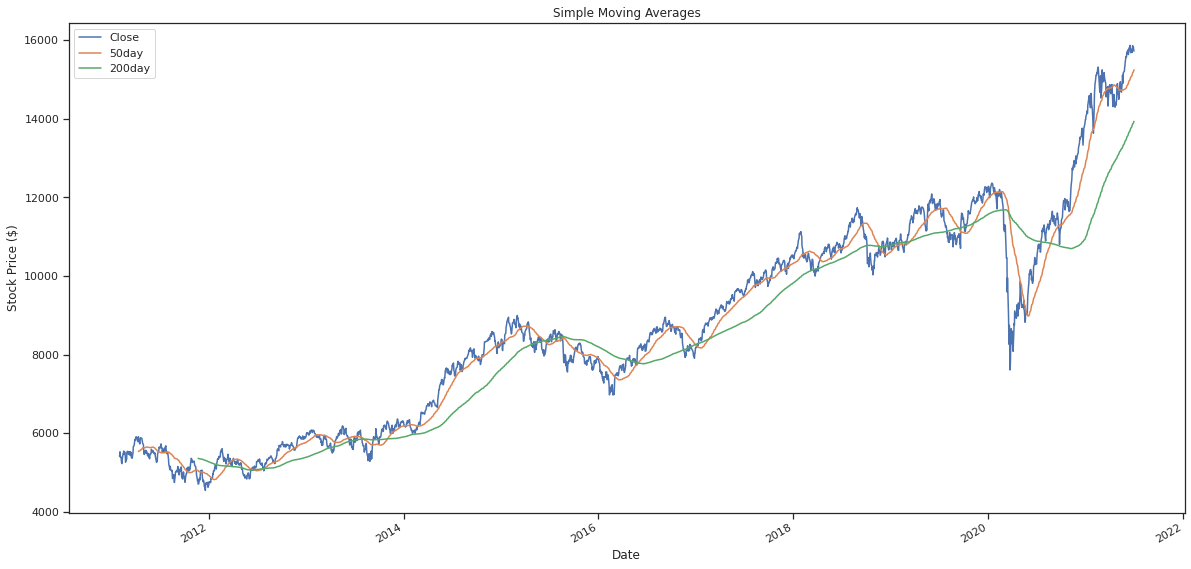

In [ ]:
window_size = 50

window_var = str(window_size) + 'day'
    
stockprices[window_var] = stockprices['Close'].rolling(window_size).mean()
### Include a 200-day SMA for reference 
stockprices['200day'] = stockprices['Close'].rolling(200).mean()
    
### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title='Simple Moving Averages', logmodelName='Simple MA')
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var, logmodelName='Simple MA')
print("RSME SMA: ", rmse_sma)
print("MAPE SMA:", mape_sma)

RSME EMA:  677.5294397178378
MAPE EMA: 4.43194914648644


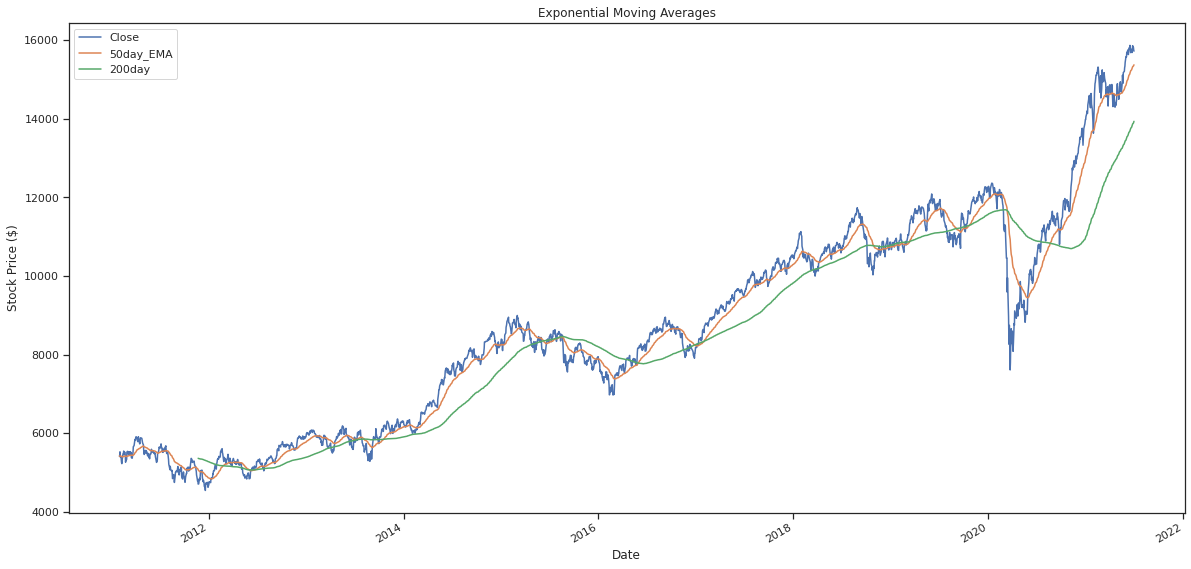

In [ ]:
###### Exponential MA
window_ema_var = window_var+'_EMA'
# Calculate the 50-day exponentially weighted moving average
stockprices[window_ema_var] = stockprices['Close'].ewm(span=window_size, adjust=False).mean()
stockprices['200day'] = stockprices['Close'].rolling(200).mean()
    
### Plot and performance metrics for EMA model
plot_stock_trend(var=window_ema_var, cur_title='Exponential Moving Averages', logmodelName='Exp MA')
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var, logmodelName='Exp MA')
print("RSME EMA: ", rmse_ema)
print("MAPE EMA:", mape_ema)

In [ ]:
#!pip install neptune-client

In [ ]:
'''import neptune.new as neptune

run = neptune.init(
    project="shreyansh55/ALDA-2021",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhOTY5MjE1Yy02OThmLTQxMjMtOGZlZi1hZmIxOGU5YTQ5NGUifQ==",
)  # your credentials

params = {"learning_rate": 0.001, "optimizer": "Adam"}
run["parameters"] = params

for epoch in range(10):
    run["train/loss"].log(0.9 ** epoch)

run["eval/f1_score"] = 0.66

run.stop()'''

'import neptune.new as neptune\n\nrun = neptune.init(\n    project="shreyansh55/ALDA-2021",\n    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhOTY5MjE1Yy02OThmLTQxMjMtOGZlZi1hZmIxOGU5YTQ5NGUifQ==",\n)  # your credentials\n\nparams = {"learning_rate": 0.001, "optimizer": "Adam"}\nrun["parameters"] = params\n\nfor epoch in range(10):\n    run["train/loss"].log(0.9 ** epoch)\n\nrun["eval/f1_score"] = 0.66\n\nrun.stop()'

In [ ]:
# scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[['Close']])
scaled_data_train = scaled_data[:train.shape[0]]
  
# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

In [ ]:
layer_units, optimizer = 50, 'adam' 
cur_epochs = 15
cur_batch_size = 20
    
cur_LSTM_pars = {'units': layer_units, 
                     'optimizer': optimizer, 
                     'batch_size': cur_batch_size, 
                     'epochs': cur_epochs
                     }

In [ ]:
def Run_LSTM(X_train, layer_units=50, logNeptune=False, NeptuneProject=None):     
    inp = Input(shape=(X_train.shape[1], 1))
    
    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inp, out)
    
    # Compile the LSTM neural net
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    ## log to Neptune, e.g., set NeptuneProject = npt_exp 
    if logNeptune:
        model.summary(print_fn=lambda x: NeptuneProject.log_text('model_summary', x))
        
    return model   


model = Run_LSTM(X_train, layer_units=layer_units)

history = model.fit(X_train, y_train, epochs=15, batch_size=cur_batch_size, 
                    verbose=1, shuffle=False)

Epoch 1/15
101/101 [==============================] - 6s 24ms/step - loss: 0.1033
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0340
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0228
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0225
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0257
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0306
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0374
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0398
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0397
Epoch 10/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0434
Epoch 11/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0424
Epoch 12/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0368
Epoch 13/15
1

In [ ]:
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):    
    raw = data['Close'][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)
    
    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price 
test['Predictions_lstm'] = predicted_price

RSME LSTM:  390.1075794617281
MAPE LSTM: 2.1927945163585374


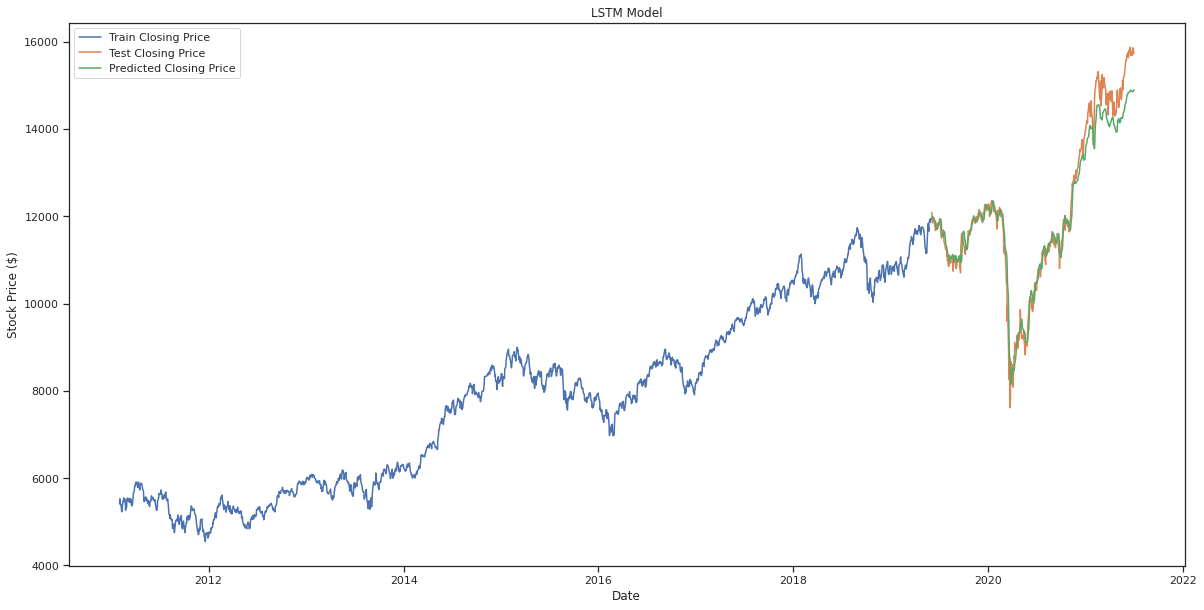

In [ ]:
# Evaluate performance
rmse_lstm = calculate_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
mape_lstm = calculate_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))

print("RSME LSTM: ", rmse_lstm)
print("MAPE LSTM:", mape_lstm)

### Plot prediction and true trends and log to Neptune         
def plot_stock_trend_lstm(train, test, logNeptune=False):        
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['Date'], train['Close'], label = 'Train Closing Price')
    plt.plot(test['Date'], test['Close'], label = 'Test Closing Price')
    plt.plot(test['Date'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")
    
    if logNeptune:
        npt_exp.log_image('Plot of Stock Predictions with LSTM', fig)
        
plot_stock_trend_lstm(train, test)

In [ ]:
'''
#Nifty 50 results
RSME SMA:  721.4152630755184
MAPE SMA: 4.5513948506604445

RSME EMA:  618.7263975865864
MAPE EMA: 3.9124566371655773

RSME LSTM:  431.29886289179024
MAPE LSTM: 2.0855405651150667
'''

'\n#Nifty 50 results\nRSME SMA:  721.4152630755184\nMAPE SMA: 4.5513948506604445\n\nRSME EMA:  618.7263975865864\nMAPE EMA: 3.9124566371655773\n\nRSME LSTM:  431.29886289179024\nMAPE LSTM: 2.0855405651150667\n'

# **Extras**